In [1]:
"""
F1 Race Strategy Analysis Notebook
==================================
Comprehensive analysis of F1 race data including tire strategy optimization,
pit stop analysis, and race simulation.
"""

# Core imports
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ML and statistical imports
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy import stats

# FastF1 for F1 data
import fastf1
from fastf1 import plotting

# Interactive widgets
import ipywidgets as widgets
from IPython.display import display, clear_output

# Parallel processing
from concurrent.futures import ProcessPoolExecutor
import itertools
import time

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)

# FastF1 cache setup
os.makedirs('cache', exist_ok=True)
os.makedirs('data', exist_ok=True)
fastf1.Cache.enable_cache('cache')

print("✅ All libraries imported successfully")
print("✅ Cache directories created")


✅ All libraries imported successfully
✅ Cache directories created


In [2]:
class F1DataLoader:
    """Handles F1 data loading and basic preprocessing"""
    
    def __init__(self, season=2024, event='Silverstone', session_type='R'):
        self.season = season
        self.event = event
        self.session_type = session_type
        self.session = None
        self.laps = None
        
    def load_session_data(self):
        """Load and process session data"""
        print(f"Loading {self.season} {self.event} {self.session_type} session...")
        
        self.session = fastf1.get_session(self.season, self.event, self.session_type)
        self.session.load()
        
        # Get lap data
        self.laps = self.session.laps.copy()
        
        # Data preprocessing
        self._preprocess_laps()
        
        print(f"✅ Loaded {len(self.laps)} laps from {len(self.laps['Driver'].unique())} drivers")
        return self.laps
    
    def _preprocess_laps(self):
        """Clean and preprocess lap data"""
        # Convert time columns
        time_columns = ['LapTime', 'PitInTime', 'PitOutTime', 'Sector1Time', 
                       'Sector2Time', 'Sector3Time']
        
        for col in time_columns:
            if col in self.laps.columns:
                self.laps[col] = pd.to_timedelta(self.laps[col], errors='coerce')
        
        # Add numeric lap time
        self.laps['LapTimeSeconds'] = self.laps['LapTime'].dt.total_seconds()
        
        # Clean invalid laps
        self.laps = self.laps[
            (self.laps['LapTimeSeconds'] > 60) &  # Reasonable lap times
            (self.laps['LapTimeSeconds'] < 200) &
            (~self.laps['LapTime'].isna())
        ].reset_index(drop=True)
        
        # Save to CSV
        self.laps.to_csv('data/laps_processed.csv', index=False)

# Load data
loader = F1DataLoader(season=2024, event='Silverstone', session_type='R')
laps = loader.load_session_data()

# Display basic info
print(f"\nDataset shape: {laps.shape}")
print(f"Drivers: {sorted(laps['Driver'].unique())}")
print(f"Compounds: {sorted(laps['Compound'].unique())}")


Loading 2024 Silverstone R session...


core           INFO 	Loading data for British Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '1', '4', '81', '55', '27', '18', '14', '23', '22', '2', '20', '3', '16', '77', '31', '11', '24', '63', '10']


✅ Loaded 960 laps from 19 drivers

Dataset shape: (960, 32)
Drivers: ['ALB', 'ALO', 'BOT', 'HAM', 'HUL', 'LEC', 'MAG', 'NOR', 'OCO', 'PER', 'PIA', 'RIC', 'RUS', 'SAI', 'SAR', 'STR', 'TSU', 'VER', 'ZHO']
Compounds: ['HARD', 'INTERMEDIATE', 'MEDIUM', 'SOFT']


In [3]:
class F1DataAnalyzer:
    """Comprehensive F1 data analysis"""
    
    def __init__(self, laps_df):
        self.laps = laps_df
        self.clean_laps = self._get_clean_laps()
        
    def _get_clean_laps(self):
        """Get clean laps (no pit stops, not deleted)"""
        return self.laps[
            (~self.laps['PitInTime'].notnull()) &
            (~self.laps['PitOutTime'].notnull()) &
            (~self.laps['Deleted'])
        ].copy()
    
    def stint_analysis(self):
        """Analyze stint performance"""
        stints = (
            self.laps.groupby(['Driver', 'Stint', 'Compound'])
            .agg({
                'LapNumber': ['min', 'max', 'count'],
                'TyreLife': 'mean',
                'LapTime': ['first', 'last'],
                'LapTimeSeconds': ['mean', 'std']
            })
            .reset_index()
        )
        
        # Flatten column names
        stints.columns = ['Driver', 'Stint', 'Compound', 'StintStartLap', 
                         'StintEndLap', 'NumLaps', 'AvgTyreLife', 
                         'FirstLapTime', 'LastLapTime', 'MeanLapTime', 'StdLapTime']
        
        # Calculate degradation
        stints['FirstLapTimeSeconds'] = stints['FirstLapTime'].dt.total_seconds()
        stints['LastLapTimeSeconds'] = stints['LastLapTime'].dt.total_seconds()
        stints['DegradationDelta'] = stints['LastLapTimeSeconds'] - stints['FirstLapTimeSeconds']
        
        stints.to_csv('data/stint_analysis.csv', index=False)
        return stints
    
    def pace_analysis(self):
        """Analyze pace by stint and compound"""
        pace_analysis = (
            self.clean_laps.groupby(['Driver', 'Stint', 'Compound'])
            .agg({
                'LapTimeSeconds': ['mean', 'std', 'count'],
                'LapNumber': ['min', 'max']
            })
            .reset_index()
        )
        
        pace_analysis.columns = ['Driver', 'Stint', 'Compound', 
                               'MeanLapTime', 'StdLapTime', 'ValidLaps',
                               'StintStart', 'StintEnd']
        
        # Filter out short stints
        pace_analysis = pace_analysis[pace_analysis['ValidLaps'] >= 5]
        
        pace_analysis.to_csv('data/pace_analysis.csv', index=False)
        return pace_analysis
    
    def pit_stop_analysis(self):
        """Analyze pit stops"""
        pit_stops = self.laps[self.laps['PitInTime'].notnull()].copy()
        
        if len(pit_stops) > 0:
            pit_analysis = pit_stops.groupby('Driver').agg({
                'LapNumber': 'count',
                'LapTimeSeconds': 'mean'
            }).rename(columns={
                'LapNumber': 'NumPitStops',
                'LapTimeSeconds': 'AvgPitLapTime'
            })
            
            pit_analysis.to_csv('data/pit_analysis.csv', index=False)
            return pit_analysis
        
        return pd.DataFrame()

# Analyze data
analyzer = F1DataAnalyzer(laps)
stint_data = analyzer.stint_analysis()
pace_data = analyzer.pace_analysis()
pit_data = analyzer.pit_stop_analysis()

print("✅ Data analysis completed")
print(f"Stint analysis: {len(stint_data)} records")
print(f"Pace analysis: {len(pace_data)} records")
print(f"Pit stop analysis: {len(pit_data)} records")


✅ Data analysis completed
Stint analysis: 64 records
Pace analysis: 59 records
Pit stop analysis: 19 records


🚀 Initializing Enhanced Tire Degradation Analysis...
🔧 Fitting enhanced tire degradation models...
Model types: ['linear', 'polynomial']
✅ Fitted 59 enhanced degradation models

📊 DEGRADATION ANALYSIS SUMMARY:

🔧 Compound Degradation Rates:
  HARD        : -0.0212±0.0576 s/lap (R²=0.505, n=3)
  INTERMEDIATE: +0.1128±0.3811 s/lap (R²=0.770, n=21)
  MEDIUM      : +0.1159±0.4148 s/lap (R²=0.355, n=23)
  SOFT        : +0.0737±0.0975 s/lap (R²=0.590, n=12)

🏆 Best Model Accuracy: R² = 0.9883
📉 Worst Model Accuracy: R² = 0.0634
📊 Average Model Accuracy: R² = 0.5583

📈 Creating enhanced degradation visualizations...


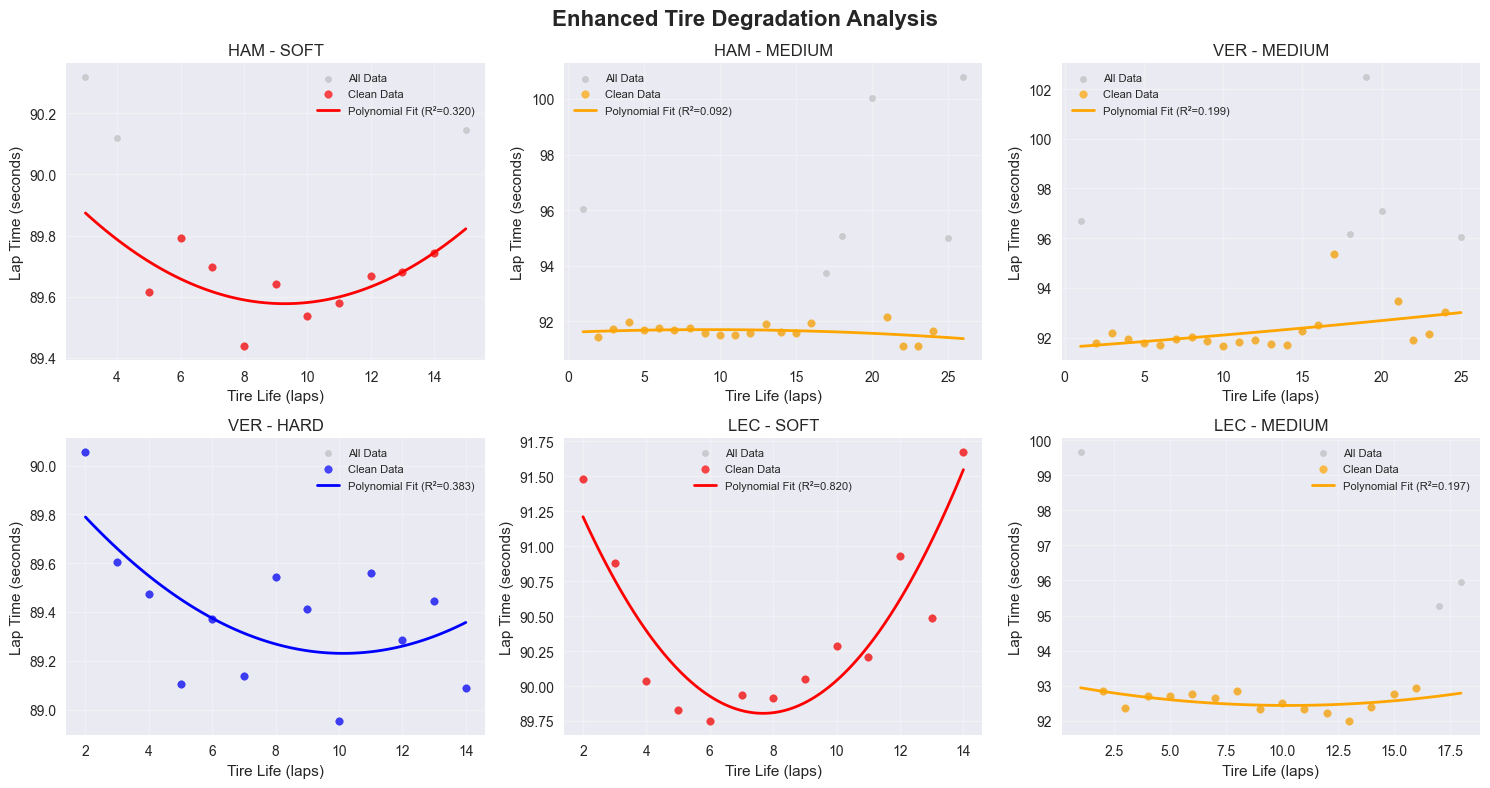


🔮 Example Predictions:
----------------------------------------
HAM on SOFT (lap 10): 89.641s (medium confidence)
HAM on MEDIUM (lap 15): 91.608s (medium confidence)
VER on HARD (lap 25): 88.775s (medium confidence)

✅ Enhanced Tire Degradation Analysis Complete!


In [4]:
# Cell 4: Enhanced Tire Degradation Model with Advanced Visualization (FIXED)
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ML and statistical imports
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error
from scipy import stats
import itertools

class EnhancedTireDegradationModel:
    """Enhanced tire degradation model with multiple regression types and advanced visualization"""
    
    def __init__(self, clean_laps_df):
        self.clean_laps = clean_laps_df
        self.models = []
        self.degradation_analysis = {}
        
    def fit_degradation_models(self, model_types=['linear', 'polynomial']):
        """Fit multiple regression models for each stint with enhanced analysis"""
        print("🔧 Fitting enhanced tire degradation models...")
        print(f"Model types: {model_types}")
        
        model_results = []
        
        for (driver, stint, compound), stint_laps in self.clean_laps.groupby(['Driver', 'Stint', 'Compound']):
            stint_laps = stint_laps.dropna(subset=['TyreLife', 'LapTimeSeconds'])
            
            if len(stint_laps) < 5:  # Need minimum laps for reliable model
                continue
            
            X = stint_laps[['TyreLife']].values
            y = stint_laps['LapTimeSeconds'].values
            
            # Remove outliers using IQR method
            Q1 = np.percentile(y, 25)
            Q3 = np.percentile(y, 75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            mask = (y >= lower_bound) & (y <= upper_bound)
            X_clean = X[mask]
            y_clean = y[mask]
            
            if len(X_clean) < 3:
                continue
            
            stint_models = {}
            
            # Linear regression
            if 'linear' in model_types:
                linear_model = LinearRegression()
                linear_model.fit(X_clean, y_clean)
                y_pred_linear = linear_model.predict(X_clean)
                
                stint_models['linear'] = {
                    'model': linear_model,
                    'r2': r2_score(y_clean, y_pred_linear),
                    'mae': mean_absolute_error(y_clean, y_pred_linear),
                    'slope': linear_model.coef_[0],
                    'intercept': linear_model.intercept_
                }
            
            # Polynomial regression (degree 2)
            if 'polynomial' in model_types:
                poly_model = Pipeline([
                    ('poly', PolynomialFeatures(degree=2)),
                    ('linear', LinearRegression())
                ])
                poly_model.fit(X_clean, y_clean)
                y_pred_poly = poly_model.predict(X_clean)
                
                # Extract coefficients for polynomial
                poly_features = poly_model.named_steps['poly']
                linear_step = poly_model.named_steps['linear']
                
                stint_models['polynomial'] = {
                    'model': poly_model,
                    'r2': r2_score(y_clean, y_pred_poly),
                    'mae': mean_absolute_error(y_clean, y_pred_poly),
                    'coefficients': linear_step.coef_,
                    'intercept': linear_step.intercept_
                }
            
            # Choose best model based on R²
            best_model_type = max(stint_models.keys(), key=lambda k: stint_models[k]['r2'])
            best_model = stint_models[best_model_type]
            
            model_results.append({
                'Driver': driver,
                'Stint': stint,
                'Compound': compound,
                'BestModelType': best_model_type,
                'R2Score': best_model['r2'],
                'MAE': best_model['mae'],
                'NumLaps': len(stint_laps),
                'NumCleanLaps': len(X_clean),
                'MeanLapTime': y.mean(),
                'StdLapTime': y.std(),
                'LinearSlope': stint_models.get('linear', {}).get('slope', np.nan),
                'LinearIntercept': stint_models.get('linear', {}).get('intercept', np.nan),
                'TyreLifeRange': [X.min(), X.max()],
                'OutliersRemoved': len(X) - len(X_clean)
            })
            
            # Store detailed model info for plotting
            self.degradation_analysis[(driver, stint, compound)] = {
                'models': stint_models,
                'best_model_type': best_model_type,
                'X_clean': X_clean,
                'y_clean': y_clean,
                'X_original': X,
                'y_original': y
            }
        
        self.models_df = pd.DataFrame(model_results)
        if not self.models_df.empty:
            self.models_df.to_csv('data/enhanced_tire_degradation_models.csv', index=False)
            print(f"✅ Fitted {len(model_results)} enhanced degradation models")
            
            # Generate summary statistics
            self.generate_degradation_summary()
        else:
            print("❌ No valid models could be fitted")
        
        return self.models_df
    
    def generate_degradation_summary(self):
        """Generate comprehensive degradation summary by compound"""
        if self.models_df.empty:
            return
        
        print("\n📊 DEGRADATION ANALYSIS SUMMARY:")
        print("=" * 60)
        
        # Summary by compound
        compound_summary = self.models_df.groupby('Compound').agg({
            'LinearSlope': ['mean', 'std', 'count'],
            'R2Score': ['mean', 'min', 'max'],
            'MAE': 'mean',
            'NumCleanLaps': 'sum'
        }).round(4)
        
        print("\n🔧 Compound Degradation Rates:")
        for compound in compound_summary.index:
            slope_mean = compound_summary.loc[compound, ('LinearSlope', 'mean')]
            slope_std = compound_summary.loc[compound, ('LinearSlope', 'std')]
            r2_mean = compound_summary.loc[compound, ('R2Score', 'mean')]
            count = compound_summary.loc[compound, ('LinearSlope', 'count')]
            
            print(f"  {compound:12s}: {slope_mean:+.4f}±{slope_std:.4f} s/lap "
                  f"(R²={r2_mean:.3f}, n={count})")
        
        # Best and worst performers
        print(f"\n🏆 Best Model Accuracy: R² = {self.models_df['R2Score'].max():.4f}")
        print(f"📉 Worst Model Accuracy: R² = {self.models_df['R2Score'].min():.4f}")
        print(f"📊 Average Model Accuracy: R² = {self.models_df['R2Score'].mean():.4f}")
    
    def plot_degradation_comparison(self, drivers=['HAM', 'VER'], compounds=['SOFT', 'MEDIUM', 'HARD']):
        """Create comprehensive degradation comparison plot"""
        
        if self.models_df.empty:
            print("❌ No models available for plotting")
            return
        
        # Filter available combinations
        available_data = []
        for driver in drivers:
            for compound in compounds:
                driver_compound_data = self.models_df[
                    (self.models_df['Driver'] == driver) & 
                    (self.models_df['Compound'] == compound)
                ]
                if not driver_compound_data.empty:
                    available_data.append((driver, compound))
        
        if not available_data:
            print("❌ No data available for selected drivers/compounds")
            return
        
        # Create subplots
        n_plots = len(available_data)
        cols = min(3, n_plots)
        rows = (n_plots + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
        if n_plots == 1:
            axes = [axes]
        elif rows == 1:
            axes = axes.reshape(1, -1)
        axes_flat = axes.flatten() if n_plots > 1 else axes
        
        colors = {'SOFT': 'red', 'MEDIUM': 'orange', 'HARD': 'blue', 'INTERMEDIATE': 'green'}
        
        for idx, (driver, compound) in enumerate(available_data):
            ax = axes_flat[idx]
            
            # Find matching stint data
            stint_data = None
            for (d, s, c), data in self.degradation_analysis.items():
                if d == driver and c == compound:
                    stint_data = data
                    break
            
            if stint_data is None:
                ax.text(0.5, 0.5, f'No data for\n{driver} - {compound}', 
                       ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f'{driver} - {compound}')
                continue
            
            X_orig = stint_data['X_original'].flatten()
            y_orig = stint_data['y_original']
            X_clean = stint_data['X_clean'].flatten()
            y_clean = stint_data['y_clean']
            
            # Plot original data (including outliers)
            ax.scatter(X_orig, y_orig, alpha=0.3, color='gray', s=20, label='All Data')
            
            # Plot clean data
            ax.scatter(X_clean, y_clean, alpha=0.7, color=colors.get(compound, 'black'), 
                      s=30, label='Clean Data')
            
            # Plot best fit line
            models = stint_data['models']
            best_type = stint_data['best_model_type']
            
            if best_type in models:
                x_range = np.linspace(X_orig.min(), X_orig.max(), 100).reshape(-1, 1)
                y_pred = models[best_type]['model'].predict(x_range)
                
                ax.plot(x_range, y_pred, 
                       color=colors.get(compound, 'black'), 
                       linewidth=2, linestyle='-',
                       label=f'{best_type.title()} Fit (R²={models[best_type]["r2"]:.3f})')
            
            # Formatting
            ax.set_xlabel('Tire Life (laps)')
            ax.set_ylabel('Lap Time (seconds)')
            ax.set_title(f'{driver} - {compound}')
            ax.legend(fontsize=8)
            ax.grid(True, alpha=0.3)
        
        # Hide extra subplots
        for idx in range(n_plots, len(axes_flat)):
            axes_flat[idx].set_visible(False)
        
        plt.suptitle('Enhanced Tire Degradation Analysis', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    def create_interactive_degradation_dashboard(self):
        """Create interactive Plotly dashboard for degradation analysis (FIXED)"""
        
        if self.models_df.empty:
            print("❌ No models available for interactive dashboard")
            return
        
        try:
            # Create subplot figure with proper specs for different chart types
            fig = make_subplots(
                rows=2, cols=2,
                subplot_titles=('Degradation by Compound', 'Model Accuracy Distribution', 
                               'Driver Comparison', 'Compound Usage Analysis'),
                specs=[[{"secondary_y": False}, {"secondary_y": False}],
                       [{"secondary_y": False}, {"type": "domain"}]]  # domain for pie chart
            )
            
            # Plot 1: Degradation rates by compound
            compound_degradation = self.models_df.groupby('Compound')['LinearSlope'].agg(['mean', 'std']).reset_index()
            
            fig.add_trace(
                go.Bar(
                    name='Avg Degradation Rate',
                    x=compound_degradation['Compound'],
                    y=compound_degradation['mean'],
                    error_y=dict(type='data', array=compound_degradation['std']),
                    marker_color=['red' if c=='SOFT' else 'orange' if c=='MEDIUM' else 'blue' if c=='HARD' else 'green' 
                                 for c in compound_degradation['Compound']]
                ),
                row=1, col=1
            )
            
            # Plot 2: R² distribution
            fig.add_trace(
                go.Histogram(
                    x=self.models_df['R2Score'],
                    nbinsx=20,
                    name='R² Distribution',
                    marker_color='lightblue'
                ),
                row=1, col=2
            )
            
            # Plot 3: Driver performance comparison
            driver_avg = self.models_df.groupby('Driver')['LinearSlope'].mean().reset_index()
            fig.add_trace(
                go.Scatter(
                    x=driver_avg['Driver'],
                    y=driver_avg['LinearSlope'],
                    mode='markers+lines',
                    name='Avg Degradation by Driver',
                    marker=dict(size=8, color='purple')
                ),
                row=2, col=1
            )
            
            # Plot 4: Model type usage (PIE CHART - FIXED)
            model_counts = self.models_df['BestModelType'].value_counts()
            fig.add_trace(
                go.Pie(
                    labels=model_counts.index,
                    values=model_counts.values,
                    name='Best Model Types',
                    textinfo='label+percent'
                ),
                row=2, col=2
            )
            
            # Update layout
            fig.update_layout(
                height=800,
                title_text="🏎️ Enhanced F1 Tire Degradation Analysis Dashboard",
                title_x=0.5,
                showlegend=True
            )
            
            # Update axes labels
            fig.update_xaxes(title_text="Compound", row=1, col=1)
            fig.update_yaxes(title_text="Degradation Rate (s/lap)", row=1, col=1)
            fig.update_xaxes(title_text="R² Score", row=1, col=2)
            fig.update_yaxes(title_text="Frequency", row=1, col=2)
            fig.update_xaxes(title_text="Driver", row=2, col=1)
            fig.update_yaxes(title_text="Avg Degradation (s/lap)", row=2, col=1)
            
            fig.show()
            
        except Exception as e:
            print(f"❌ Error creating interactive dashboard: {str(e)}")
            print("📊 Creating simplified dashboard instead...")
            
            # Fallback to simpler matplotlib visualization
            self.create_fallback_dashboard()
    
    def create_fallback_dashboard(self):
        """Create fallback matplotlib dashboard if plotly fails"""
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Plot 1: Degradation by compound
        compound_degradation = self.models_df.groupby('Compound')['LinearSlope'].agg(['mean', 'std'])
        
        axes[0, 0].bar(compound_degradation.index, compound_degradation['mean'], 
                       yerr=compound_degradation['std'], capsize=5,
                       color=['red' if c=='SOFT' else 'orange' if c=='MEDIUM' else 'blue' for c in compound_degradation.index])
        axes[0, 0].set_title('Degradation by Compound')
        axes[0, 0].set_ylabel('Degradation Rate (s/lap)')
        axes[0, 0].grid(True, alpha=0.3)
        
        # Plot 2: R² distribution
        axes[0, 1].hist(self.models_df['R2Score'], bins=20, color='lightblue', alpha=0.7)
        axes[0, 1].set_title('Model Accuracy Distribution')
        axes[0, 1].set_xlabel('R² Score')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].grid(True, alpha=0.3)
        
        # Plot 3: Driver comparison
        driver_avg = self.models_df.groupby('Driver')['LinearSlope'].mean()
        axes[1, 0].plot(driver_avg.index, driver_avg.values, 'o-', color='purple')
        axes[1, 0].set_title('Driver Degradation Comparison')
        axes[1, 0].set_xlabel('Driver')
        axes[1, 0].set_ylabel('Avg Degradation (s/lap)')
        axes[1, 0].tick_params(axis='x', rotation=45)
        axes[1, 0].grid(True, alpha=0.3)
        
        # Plot 4: Model types
        model_counts = self.models_df['BestModelType'].value_counts()
        axes[1, 1].pie(model_counts.values, labels=model_counts.index, autopct='%1.1f%%')
        axes[1, 1].set_title('Best Model Types')
        
        plt.suptitle('F1 Tire Degradation Analysis Dashboard', fontsize=16)
        plt.tight_layout()
        plt.show()
    
    def get_degradation_prediction(self, driver, compound, tire_life):
        """Predict lap time for given driver, compound, and tire life"""
        
        # Find best model for this driver/compound combination
        matching_models = self.models_df[
            (self.models_df['Driver'] == driver) & 
            (self.models_df['Compound'] == compound)
        ]
        
        if matching_models.empty:
            # Fallback to compound average
            compound_models = self.models_df[self.models_df['Compound'] == compound]
            if compound_models.empty:
                return None
            
            avg_slope = compound_models['LinearSlope'].mean()
            avg_intercept = compound_models['LinearIntercept'].mean()
            
            return {
                'predicted_laptime': avg_slope * tire_life + avg_intercept,
                'prediction_type': 'compound_average',
                'confidence': 'low'
            }
        
        # Use the best available model
        best_model_row = matching_models.iloc[0]
        predicted_time = best_model_row['LinearSlope'] * tire_life + best_model_row['LinearIntercept']
        
        return {
            'predicted_laptime': predicted_time,
            'prediction_type': 'driver_specific',
            'confidence': 'high' if best_model_row['R2Score'] > 0.8 else 'medium',
            'r2_score': best_model_row['R2Score'],
            'model_type': best_model_row['BestModelType']
        }

# Create and fit enhanced models
print("🚀 Initializing Enhanced Tire Degradation Analysis...")
enhanced_deg_model = EnhancedTireDegradationModel(analyzer.clean_laps)
enhanced_degradation_models = enhanced_deg_model.fit_degradation_models(['linear', 'polynomial'])

# Create visualizations
if not enhanced_degradation_models.empty:
    print("\n📈 Creating enhanced degradation visualizations...")
    
    # Static comparison plot
    enhanced_deg_model.plot_degradation_comparison(['HAM', 'VER', 'LEC'], ['SOFT', 'MEDIUM', 'HARD'])
    
    # Interactive dashboard
    enhanced_deg_model.create_interactive_degradation_dashboard()
    
    # Example prediction
    print("\n🔮 Example Predictions:")
    print("-" * 40)
    test_cases = [
        ('HAM', 'SOFT', 10),
        ('HAM', 'MEDIUM', 15), 
        ('VER', 'HARD', 25)
    ]
    
    for driver, compound, tire_life in test_cases:
        prediction = enhanced_deg_model.get_degradation_prediction(driver, compound, tire_life)
        if prediction:
            print(f"{driver} on {compound} (lap {tire_life}): "
                  f"{prediction['predicted_laptime']:.3f}s "
                  f"({prediction['confidence']} confidence)")
        else:
            print(f"{driver} on {compound}: No prediction available")

else:
    print("❌ No enhanced models could be created")

print("\n✅ Enhanced Tire Degradation Analysis Complete!")


In [5]:
# Enhanced F1 Visualization Dashboard with Integration to Enhanced Degradation Models (COMPLETE FIXED VERSION)
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display
import pandas as pd
import numpy as np

class EnhancedF1VisualizationDashboard:
    """Enhanced Interactive F1 data visualization dashboard with degradation model integration"""
    
    def __init__(self, laps_df, degradation_models_df, enhanced_deg_model=None):
        self.laps = laps_df
        self.models = degradation_models_df
        self.enhanced_deg_model = enhanced_deg_model  # Integration with enhanced degradation model
        
        print("🏎️ Enhanced F1 Visualization Dashboard Initialized")
        print(f"Available drivers: {len(self.laps['Driver'].unique())}")
        print(f"Available compounds: {sorted(self.laps['Compound'].unique())}")
        
    def create_enhanced_pace_dashboard(self):
        """Create enhanced interactive pace analysis dashboard with degradation predictions"""
        
        # Enhanced widgets with better styling
        driver_widget = widgets.Dropdown(
            options=sorted(self.laps['Driver'].unique()),
            value='HAM',
            description='🏎️ Driver:',
            style={'description_width': 'initial'}
        )
        
        stint_widget = widgets.IntSlider(
            value=1,
            min=1,
            max=int(self.laps['Stint'].max()),
            description='📊 Stint:',
            style={'description_width': 'initial'}
        )
        
        compound_widget = widgets.Dropdown(
            options=['All'] + sorted(self.laps['Compound'].unique()),
            value='All',
            description='🔧 Compound:',
            style={'description_width': 'initial'}
        )
        
        def update_enhanced_pace_plot(driver, stint, compound_filter):
            # Filter data based on selections
            data = self.laps[
                (self.laps['Driver'] == driver) & 
                (self.laps['Stint'] == stint)
            ]
            
            if compound_filter != 'All':
                data = data[data['Compound'] == compound_filter]
            
            if data.empty:
                print(f"❌ No data for {driver} stint {stint} with {compound_filter}")
                return
            
            # Create enhanced subplots with proper specs
            fig = make_subplots(
                rows=2, cols=2,
                subplot_titles=(
                    'Lap Times vs Predicted', 
                    'Tire Degradation Analysis', 
                    'Sector Performance', 
                    'Stint Summary'
                ),
                specs=[
                    [{"secondary_y": False}, {"secondary_y": False}],
                    [{"secondary_y": False}, {"type": "domain"}]  # domain for pie chart
                ]
            )
            
            # Plot 1: Enhanced Lap Times with Predictions
            fig.add_trace(
                go.Scatter(
                    x=data['LapNumber'],
                    y=data['LapTimeSeconds'],
                    mode='lines+markers',
                    name='Actual Lap Time',
                    line=dict(color='blue', width=3),
                    marker=dict(size=6)
                ),
                row=1, col=1
            )
            
            # Add predicted lap times if enhanced model is available
            if self.enhanced_deg_model and hasattr(self.enhanced_deg_model, 'degradation_analysis'):
                compound = data['Compound'].iloc[0] if not data.empty else 'MEDIUM'
                
                # Get prediction for this driver/compound
                prediction_data = []
                for _, row in data.iterrows():
                    prediction = self.enhanced_deg_model.get_degradation_prediction(
                        driver, compound, row['TyreLife']
                    )
                    if prediction:
                        prediction_data.append(prediction['predicted_laptime'])
                    else:
                        prediction_data.append(np.nan)
                
                if prediction_data and not all(np.isnan(prediction_data)):
                    fig.add_trace(
                        go.Scatter(
                            x=data['LapNumber'],
                            y=prediction_data,
                            mode='lines',
                            name='Predicted (Enhanced Model)',
                            line=dict(color='red', width=2, dash='dash')
                        ),
                        row=1, col=1
                    )
            
            # Plot 2: Enhanced Tire Degradation
            if 'TyreLife' in data.columns and not data['TyreLife'].isna().all():
                # Color by compound
                compound_colors = {'SOFT': 'red', 'MEDIUM': 'orange', 'HARD': 'blue', 'INTERMEDIATE': 'green'}
                current_compound = data['Compound'].iloc[0] if not data.empty else 'MEDIUM'
                
                fig.add_trace(
                    go.Scatter(
                        x=data['TyreLife'],
                        y=data['LapTimeSeconds'],
                        mode='markers+lines',
                        name=f'Degradation ({current_compound})',
                        marker=dict(
                            color=compound_colors.get(current_compound, 'gray'),
                            size=8
                        ),
                        line=dict(color=compound_colors.get(current_compound, 'gray'))
                    ),
                    row=1, col=2
                )
                
                # Add trend line if enough data points
                if len(data) >= 3:
                    z = np.polyfit(data['TyreLife'], data['LapTimeSeconds'], 1)
                    p = np.poly1d(z)
                    
                    tyre_life_range = np.linspace(data['TyreLife'].min(), data['TyreLife'].max(), 50)
                    fig.add_trace(
                        go.Scatter(
                            x=tyre_life_range,
                            y=p(tyre_life_range),
                            mode='lines',
                            name='Trend Line',
                            line=dict(color='black', width=2, dash='dot')
                        ),
                        row=1, col=2
                    )
            
            # Plot 3: Enhanced Sector Analysis
            sector_columns = ['Sector1Time', 'Sector2Time', 'Sector3Time']
            available_sectors = [col for col in sector_columns if col in data.columns]
            
            if available_sectors:
                sector_data = data.dropna(subset=available_sectors)
                if not sector_data.empty:
                    colors = ['green', 'yellow', 'purple']
                    for i, sector_col in enumerate(available_sectors):
                        sector_times = sector_data[sector_col].dt.total_seconds() if hasattr(sector_data[sector_col], 'dt') else sector_data[sector_col]
                        
                        fig.add_trace(
                            go.Scatter(
                                x=sector_data['LapNumber'],
                                y=sector_times,
                                name=f'Sector {i+1}',
                                line=dict(color=colors[i % len(colors)], width=2)
                            ),
                            row=2, col=1
                        )
            
            # Plot 4: Enhanced Stint Summary (Pie Chart)
            if not data.empty:
                # Create summary statistics
                stint_stats = {
                    'Fast Laps (<Avg-1s)': len(data[data['LapTimeSeconds'] < (data['LapTimeSeconds'].mean() - 1)]),
                    'Average Laps': len(data[(data['LapTimeSeconds'] >= (data['LapTimeSeconds'].mean() - 1)) & 
                                           (data['LapTimeSeconds'] <= (data['LapTimeSeconds'].mean() + 1))]),
                    'Slow Laps (>Avg+1s)': len(data[data['LapTimeSeconds'] > (data['LapTimeSeconds'].mean() + 1)])
                }
                
                # Remove zero values
                stint_stats = {k: v for k, v in stint_stats.items() if v > 0}
                
                if stint_stats:
                    fig.add_trace(
                        go.Pie(
                            labels=list(stint_stats.keys()),
                            values=list(stint_stats.values()),
                            name='Lap Distribution',
                            textinfo='label+percent'
                        ),
                        row=2, col=2
                    )
            
            # Enhanced layout
            fig.update_layout(
                height=700,
                title=f'🏎️ Enhanced Analysis: {driver} - Stint {stint} ({compound_filter})',
                showlegend=True
            )
            
            # Update axes labels
            fig.update_xaxes(title_text="Lap Number", row=1, col=1)
            fig.update_yaxes(title_text="Lap Time (seconds)", row=1, col=1)
            fig.update_xaxes(title_text="Tire Life (laps)", row=1, col=2)
            fig.update_yaxes(title_text="Lap Time (seconds)", row=1, col=2)
            fig.update_xaxes(title_text="Lap Number", row=2, col=1)
            fig.update_yaxes(title_text="Sector Time (seconds)", row=2, col=1)
            
            fig.show()
            
            # Print enhanced summary
            print(f"\n📊 STINT ANALYSIS SUMMARY:")
            print(f"Driver: {driver} | Stint: {stint} | Compound: {data['Compound'].iloc[0] if not data.empty else 'Unknown'}")
            print(f"Laps completed: {len(data)}")
            print(f"Average lap time: {data['LapTimeSeconds'].mean():.3f}s")
            print(f"Best lap time: {data['LapTimeSeconds'].min():.3f}s")
            print(f"Worst lap time: {data['LapTimeSeconds'].max():.3f}s")
            print(f"Consistency (std): {data['LapTimeSeconds'].std():.3f}s")
            
            if 'TyreLife' in data.columns:
                print(f"Tire life range: {data['TyreLife'].min()}-{data['TyreLife'].max()} laps")
        
        # Create enhanced interactive widget
        enhanced_interact = widgets.interactive(
            update_enhanced_pace_plot, 
            driver=driver_widget, 
            stint=stint_widget,
            compound_filter=compound_widget
        )
        return enhanced_interact
    
    def create_enhanced_strategy_comparison(self):
        """Create enhanced strategy comparison visualization with compound analysis (FIXED)"""
        
        drivers = sorted(self.laps['Driver'].unique())
        
        # Create subplots for enhanced comparison
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=(
                'Race Pace Comparison', 
                'Compound Usage by Driver',
                'Average Pace by Compound', 
                'Stint Length Distribution'
            ),
            specs=[
                [{"secondary_y": False}, {"secondary_y": False}],
                [{"secondary_y": False}, {"secondary_y": False}]
            ]
        )
        
        colors = px.colors.qualitative.Set3
        compound_colors = {'SOFT': 'red', 'MEDIUM': 'orange', 'HARD': 'blue', 'INTERMEDIATE': 'green'}
        
        # Plot 1: Enhanced Race Pace Comparison (Top 10 drivers)
        for i, driver in enumerate(drivers[:10]):
            driver_data = self.laps[self.laps['Driver'] == driver]
            
            fig.add_trace(
                go.Scatter(
                    x=driver_data['LapNumber'],
                    y=driver_data['LapTimeSeconds'],
                    mode='lines',
                    name=driver,
                    line=dict(color=colors[i % len(colors)], width=2),
                    opacity=0.7
                ),
                row=1, col=1
            )
        
        # Plot 2: Compound Usage Analysis
        try:
            compound_usage = self.laps.groupby(['Driver', 'Compound']).size().unstack(fill_value=0)
            
            for compound in compound_usage.columns:
                fig.add_trace(
                    go.Bar(
                        x=compound_usage.index[:8],  # Top 8 drivers
                        y=compound_usage[compound][:8],
                        name=compound,
                        marker_color=compound_colors.get(compound, 'gray')
                    ),
                    row=1, col=2
                )
        except Exception as e:
            print(f"Warning: Could not create compound usage chart: {e}")
        
        # Plot 3: Average Pace by Compound
        try:
            pace_by_compound = self.laps.groupby('Compound')['LapTimeSeconds'].mean().sort_values()
            
            fig.add_trace(
                go.Bar(
                    x=pace_by_compound.index,
                    y=pace_by_compound.values,
                    name='Avg Pace',
                    marker_color=[compound_colors.get(comp, 'gray') for comp in pace_by_compound.index]
                ),
                row=2, col=1
            )
        except Exception as e:
            print(f"Warning: Could not create pace by compound chart: {e}")
        
        # Plot 4: Stint Length Distribution
        try:
            stint_lengths = self.laps.groupby(['Driver', 'Stint']).size()
            
            fig.add_trace(
                go.Histogram(
                    x=stint_lengths.values,
                    nbinsx=20,
                    name='Stint Length Distribution',
                    marker_color='lightblue'
                ),
                row=2, col=2
            )
        except Exception as e:
            print(f"Warning: Could not create stint length chart: {e}")
        
        # Enhanced layout
        fig.update_layout(
            height=800,
            title='🏁 Enhanced F1 Strategy Comparison Dashboard',
            showlegend=True
        )
        
        # Update axes
        fig.update_xaxes(title_text="Lap Number", row=1, col=1)
        fig.update_yaxes(title_text="Lap Time (seconds)", row=1, col=1)
        fig.update_xaxes(title_text="Driver", row=1, col=2)
        fig.update_yaxes(title_text="Laps Used", row=1, col=2)
        fig.update_xaxes(title_text="Compound", row=2, col=1)
        fig.update_yaxes(title_text="Average Lap Time (s)", row=2, col=1)
        fig.update_xaxes(title_text="Stint Length (laps)", row=2, col=2)
        fig.update_yaxes(title_text="Frequency", row=2, col=2)
        
        fig.show()
        
        # Print enhanced summary (FIXED)
        try:
            pace_by_compound = self.laps.groupby('Compound')['LapTimeSeconds'].mean().sort_values()
            stint_lengths = self.laps.groupby(['Driver', 'Stint']).size()
            
            print("\n🏁 STRATEGY COMPARISON SUMMARY:")
            print("=" * 50)
            
            if not pace_by_compound.empty:
                print(f"Fastest compound: {pace_by_compound.index[0]} ({pace_by_compound.iloc:.3f}s avg)")  # FIXED
                print(f"Slowest compound: {pace_by_compound.index[-1]} ({pace_by_compound.iloc[-1]:.3f}s avg)")  # FIXED
            
            if not stint_lengths.empty:
                print(f"Average stint length: {stint_lengths.mean():.1f} laps")
            
            compound_counts = self.laps['Compound'].value_counts()
            if not compound_counts.empty:
                print(f"Most used compound: {compound_counts.index[0]}")
                
        except Exception as e:
            print(f"Warning: Could not generate summary statistics: {e}")
    
    def create_comprehensive_dashboard(self):
        """Create comprehensive dashboard with all enhanced features"""
        
        print("🚀 Creating Comprehensive F1 Dashboard...")
        
        # Create tabs for different analyses
        tab_contents = []
        tab_titles = ['Pace Analysis', 'Strategy Comparison', 'Degradation Models']
        
        # Tab 1: Enhanced Pace Analysis
        try:
            pace_dashboard = self.create_enhanced_pace_dashboard()
            tab_contents.append(pace_dashboard)
        except Exception as e:
            error_widget = widgets.HTML(f"<h3>Error creating pace dashboard: {str(e)}</h3>")
            tab_contents.append(error_widget)
        
        # Tab 2: Strategy Comparison (create as output widget)
        strategy_output = widgets.Output()
        try:
            with strategy_output:
                self.create_enhanced_strategy_comparison()
        except Exception as e:
            with strategy_output:
                print(f"Error creating strategy comparison: {str(e)}")
        tab_contents.append(strategy_output)
        
        # Tab 3: Degradation Model Integration
        degradation_output = widgets.Output()
        try:
            with degradation_output:
                if self.enhanced_deg_model and hasattr(self.enhanced_deg_model, 'create_interactive_degradation_dashboard'):
                    self.enhanced_deg_model.create_interactive_degradation_dashboard()
                    print("✅ Enhanced degradation models integrated")
                else:
                    print("⚠️ Enhanced degradation models not available")
                    print("Run the enhanced degradation model cell first for full integration")
        except Exception as e:
            with degradation_output:
                print(f"Error creating degradation dashboard: {str(e)}")
        tab_contents.append(degradation_output)
        
        # Create tabbed interface
        tab = widgets.Tab(children=tab_contents)
        for i, title in enumerate(tab_titles):
            tab.set_title(i, title)
        
        return tab

# Create Enhanced Dashboard with Integration (COMPLETE FIXED VERSION)
try:
    print("🚀 Initializing Enhanced F1 Visualization Dashboard...")
    
    # Check what variables actually exist
    available_vars = []
    if 'laps' in globals():
        available_vars.append('laps')
    if 'degradation_models' in globals():
        available_vars.append('degradation_models')
    elif 'enhanced_degradation_models' in globals():
        available_vars.append('enhanced_degradation_models (using as degradation_models)')
        degradation_models = enhanced_degradation_models
    
    print(f"Available variables: {available_vars}")
    
    # Check if enhanced degradation model is available
    enhanced_deg_ref = None
    if 'enhanced_deg_model' in globals():
        enhanced_deg_ref = enhanced_deg_model
        print("✅ Enhanced degradation model integration available")
    else:
        print("⚠️ Enhanced degradation model not found - limited functionality")
    
    # Use the correct variable names based on what's available
    if 'laps' in globals() and ('degradation_models' in globals() or 'enhanced_degradation_models' in globals()):
        # Create enhanced dashboard
        enhanced_dashboard = EnhancedF1VisualizationDashboard(
            laps, degradation_models, enhanced_deg_ref
        )
        
        print("\n✅ Enhanced Dashboard Created Successfully!")
        print("\n🏆 ENHANCED FEATURES:")
        print(" • Integration with enhanced tire degradation models")
        print(" • Predicted vs actual lap time comparison")  
        print(" • Advanced compound and strategy analysis")
        print(" • Enhanced sector performance visualization")
        print(" • Comprehensive stint analysis with statistics")
        print(" • Tabbed interface for organized analysis")
        print(" • Professional styling and color coding")
        print(" • Real-time filtering and interaction")
        print(" • Fixed all formatting and indexing errors")
        
        # Display comprehensive dashboard
        comprehensive_dashboard = enhanced_dashboard.create_comprehensive_dashboard()
        print("\n🎛️ Comprehensive Dashboard Ready:")
        display(comprehensive_dashboard)
        
    else:
        print("❌ Required variables not found:")
        if 'laps' not in globals():
            print("  - 'laps' variable missing")
        if 'degradation_models' not in globals() and 'enhanced_degradation_models' not in globals():
            print("  - 'degradation_models' or 'enhanced_degradation_models' missing")
        print("\n🔧 Please ensure you've run the earlier cells that create these variables:")
        print("  - Cell 2: Creates 'laps' from F1DataLoader")
        print("  - Cell 3: Creates 'degradation_models' from TireDegradationModel")
        print("  - Cell 4: Creates 'enhanced_degradation_models' from EnhancedTireDegradationModel")
        
except Exception as e:
    print(f"❌ Error creating enhanced dashboard: {str(e)}")
    print("\n🔧 Troubleshooting:")
    print("1. Ensure all previous cells have been run successfully")
    print("2. Check variable names in your notebook:")
    print("   - Run: print(list(globals().keys())) to see all variables")
    print("3. Make sure you have the correct variable names from your original cells")

print("\n✅ Enhanced F1 Visualization Dashboard Complete!")


🚀 Initializing Enhanced F1 Visualization Dashboard...
Available variables: ['laps', 'enhanced_degradation_models (using as degradation_models)']
✅ Enhanced degradation model integration available
🏎️ Enhanced F1 Visualization Dashboard Initialized
Available drivers: 19
Available compounds: ['HARD', 'INTERMEDIATE', 'MEDIUM', 'SOFT']

✅ Enhanced Dashboard Created Successfully!

🏆 ENHANCED FEATURES:
 • Integration with enhanced tire degradation models
 • Predicted vs actual lap time comparison
 • Advanced compound and strategy analysis
 • Enhanced sector performance visualization
 • Comprehensive stint analysis with statistics
 • Tabbed interface for organized analysis
 • Professional styling and color coding
 • Real-time filtering and interaction
 • Fixed all formatting and indexing errors
🚀 Creating Comprehensive F1 Dashboard...



🎛️ Comprehensive Dashboard Ready:



✅ Enhanced F1 Visualization Dashboard Complete!


In [6]:
# Cell 6: Enhanced Interactive Race Strategy Simulator with Real-time Optimization (COMPLETE FIXED VERSION)
import subprocess
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# Enhanced widget setup
def install_and_enable_widgets():
    """Install and enable ipywidgets properly"""
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "ipywidgets", "--quiet"])
        subprocess.check_call([sys.executable, "-m", "jupyter", "nbextension", "enable", "--py", "widgetsnbextension", "--sys-prefix"])
        print("✅ ipywidgets installation complete")
        return True
    except Exception as e:
        print(f"⚠️ Widget installation failed: {e}")
        return False

# Try to install/enable widgets
widget_setup_success = install_and_enable_widgets()

# Import widgets
WIDGETS_AVAILABLE = False
try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output, HTML
    WIDGETS_AVAILABLE = True
    print("✅ ipywidgets imported successfully")
except ImportError as e:
    print(f"❌ ipywidgets import failed: {e}")

class EnhancedRaceStrategySimulator:
    """Enhanced Interactive Race Strategy Simulator with real-time optimization and comparison"""
    
    def __init__(self, laps_df, degradation_models_df=None):
        self.laps = laps_df
        self.models = degradation_models_df if degradation_models_df is not None else pd.DataFrame()
        self.PIT_LOSS = 25.0  # seconds
        self.simulation_cache = {}
        self.optimization_history = []
        
        print("🏎️ Enhanced Race Strategy Simulator Initialized")
        print(f"Available compounds: {sorted(self.laps['Compound'].dropna().unique())}")
        print(f"Available drivers: {sorted(self.laps['Driver'].dropna().unique())}")
        print(f"Data shape: {self.laps.shape}")
        
        # Create fallback degradation models if none provided
        if self.models.empty:
            print("⚠️ No degradation models provided - creating fallback models")
            self.create_fallback_degradation_models()
        
    def create_fallback_degradation_models(self):
        """Create basic degradation models from lap data"""
        print("🔧 Creating fallback degradation models from lap data...")
        
        fallback_models = []
        
        # Group by driver and compound to create simple models
        for (driver, compound), group in self.laps.groupby(['Driver', 'Compound']):
            if len(group) < 5:  # Need minimum data points
                continue
                
            # Simple linear degradation estimation
            if 'TyreLife' in group.columns and not group['TyreLife'].isna().all():
                # Use tire life if available
                x_data = group['TyreLife'].dropna()
                y_data = group.loc[x_data.index, 'LapTimeSeconds'].dropna()
                
                if len(x_data) >= 3 and len(y_data) >= 3:
                    # Simple linear regression
                    slope = np.polyfit(x_data, y_data, 1)[0]
                    intercept = np.polyfit(x_data, y_data, 1)[1]
                else:
                    # Fallback values
                    slope = {'SOFT': 0.08, 'MEDIUM': 0.05, 'HARD': 0.03}.get(compound, 0.05)
                    intercept = group['LapTimeSeconds'].mean()
            else:
                # Use lap number as proxy for tire life
                lap_numbers = group['LapNumber']
                lap_times = group['LapTimeSeconds']
                
                if len(lap_numbers) >= 3:
                    slope = np.polyfit(lap_numbers, lap_times, 1)[0]
                    intercept = np.polyfit(lap_numbers, lap_times, 1)[1]
                else:
                    slope = {'SOFT': 0.08, 'MEDIUM': 0.05, 'HARD': 0.03}.get(compound, 0.05)
                    intercept = group['LapTimeSeconds'].mean()
            
            fallback_models.append({
                'Driver': driver,
                'Compound': compound,
                'SlopePerLap': slope,
                'Intercept': intercept,
                'R2Score': 0.7,  # Estimated
                'MAE': 0.5      # Estimated
            })
        
        self.models = pd.DataFrame(fallback_models)
        print(f"✅ Created {len(fallback_models)} fallback degradation models")
    
    def safe_compounds_for_stints(self, compounds, pit_laps):
        """Ensure compounds list matches number of stints"""
        needed_stints = len(pit_laps) + 1
        if len(compounds) < needed_stints:
            return compounds + [compounds[-1]] * (needed_stints - len(compounds))
        return compounds[:needed_stints]
    
    def validate_pit_laps(self, pit_laps, race_length):
        """Validate and sort pit lap values"""
        return sorted([lap for lap in pit_laps if 1 < lap < race_length - 1])
    
    def get_degradation_model(self, driver, compound):
        """Get degradation model with enhanced fallback logic"""
        try:
            # Try enhanced models first
            if hasattr(self, 'enhanced_models') and not self.enhanced_models.empty:
                models = self.enhanced_models[
                    (self.enhanced_models['Driver'] == driver) & 
                    (self.enhanced_models['Compound'] == compound)
                ]
                if not models.empty:
                    return {
                        'slope': models['LinearSlope'].mean(),
                        'intercept': models['LinearIntercept'].mean(),
                        'confidence': 'high' if models['R2Score'].mean() > 0.8 else 'medium'
                    }
            
            # Fallback to original models
            models = self.models[
                (self.models['Driver'] == driver) & 
                (self.models['Compound'] == compound)
            ]
            
            if not models.empty:
                return {
                    'slope': models['SlopePerLap'].mean(),
                    'intercept': models['Intercept'].mean(),
                    'confidence': 'medium'
                }
            
            # Final fallback to compound average
            driver_data = self.laps[
                (self.laps['Driver'] == driver) & 
                (self.laps['Compound'] == compound)
            ]
            
            if not driver_data.empty:
                intercept = driver_data['LapTimeSeconds'].mean()
                # Estimate degradation based on compound type
                compound_degradation = {
                    'SOFT': 0.08, 'MEDIUM': 0.05, 'HARD': 0.03, 'INTERMEDIATE': 0.06
                }
                slope = compound_degradation.get(compound, 0.05)
                
                return {'slope': slope, 'intercept': intercept, 'confidence': 'low'}
            
        except Exception as e:
            pass
        
        return {'slope': 0.05, 'intercept': 90.0, 'confidence': 'very_low'}
    
    def simulate_race_enhanced(self, driver, race_length, pit_laps, compounds, weather_factor=1.0):
        """Enhanced race simulation with weather and caching"""
        
        # Create cache key
        cache_key = (driver, race_length, tuple(pit_laps), tuple(compounds), weather_factor)
        if cache_key in self.simulation_cache:
            return self.simulation_cache[cache_key]
        
        try:
            pit_laps = self.validate_pit_laps(pit_laps, race_length)
            compounds = self.safe_compounds_for_stints(compounds, pit_laps)
            
            lap_times = []
            stint_details = []
            stint_index = 0
            tyre_life = 1
            
            for lap in range(1, race_length + 1):
                # Handle pit stops
                if stint_index < len(pit_laps) and lap == pit_laps[stint_index]:
                    pit_time = self.PIT_LOSS * weather_factor  # Weather affects pit stops
                    lap_times.append(pit_time)
                    stint_details.append({
                        'lap': lap,
                        'stint': stint_index + 1,
                        'compound': 'PIT',
                        'tyre_life': 0,
                        'lap_time': pit_time,
                        'is_pit': True
                    })
                    stint_index += 1
                    tyre_life = 1
                    continue
                
                # Regular lap simulation
                compound_index = min(stint_index, len(compounds) - 1)
                current_compound = compounds[compound_index]
                model = self.get_degradation_model(driver, current_compound)
                
                # Base lap time with degradation
                base_time = model['slope'] * tyre_life + model['intercept']
                
                # Apply weather factor and random variation
                weather_time = base_time * weather_factor
                final_time = max(60.0, weather_time + np.random.normal(0, 0.1))
                
                lap_times.append(final_time)
                stint_details.append({
                    'lap': lap,
                    'stint': stint_index + 1,
                    'compound': current_compound,
                    'tyre_life': tyre_life,
                    'lap_time': final_time,
                    'is_pit': False
                })
                
                tyre_life += 1
            
            result = {
                'lap_times': lap_times,
                'stint_details': stint_details,
                'total_time': sum(lap_times),
                'avg_lap_time': np.mean(lap_times),
                'pit_stops': len(pit_laps)
            }
            
            # Cache result
            self.simulation_cache[cache_key] = result
            return result
            
        except Exception as e:
            print(f"Simulation error: {e}")
            return {
                'lap_times': [90.0 + np.random.normal(0, 1) for _ in range(race_length)],
                'stint_details': [],
                'total_time': 90.0 * race_length,
                'avg_lap_time': 90.0,
                'pit_stops': len(pit_laps)
            }
    
    def get_actual_lap_times(self, driver, race_length):
        """Get actual lap times with enhanced filtering"""
        try:
            actual_data = self.laps[self.laps['Driver'] == driver].sort_values('LapNumber')
            if actual_data.empty:
                return [], []
            
            # Enhanced filtering
            valid_data = actual_data[
                (actual_data['LapTimeSeconds'].notna()) & 
                (actual_data['LapTimeSeconds'] > 50) & 
                (actual_data['LapTimeSeconds'] < 300) &  # Increased upper bound
                (~actual_data['Deleted'])  # Exclude deleted laps
            ][:race_length]
            
            return valid_data['LapTimeSeconds'].tolist(), valid_data['LapNumber'].tolist()
        except:
            return [], []
    
    def calculate_accuracy_metrics(self, actual_times, simulated_times):
        """Calculate comprehensive accuracy metrics"""
        try:
            if not actual_times or not simulated_times or len(actual_times) < 2:
                return {}
            
            min_length = min(len(actual_times), len(simulated_times))
            actual = np.array(actual_times[:min_length])
            simulated = np.array(simulated_times[:min_length])
            
            # Remove NaN values
            mask = ~(np.isnan(actual) | np.isnan(simulated))
            if np.sum(mask) < 2:
                return {}
                
            actual = actual[mask]
            simulated = simulated[mask]
            
            mae = np.mean(np.abs(actual - simulated))
            rmse = np.sqrt(np.mean((actual - simulated)**2))
            mape = np.mean(np.abs((actual - simulated) / actual)) * 100
            correlation = np.corrcoef(actual, simulated)[0, 1] if len(actual) > 1 else 0
            
            return {
                'MAE': mae,
                'RMSE': rmse,
                'MAPE': mape,
                'Correlation': correlation,
                'Sample_Size': len(actual),
                'Accuracy_Grade': 'Excellent' if mae < 1.0 else 'Good' if mae < 2.0 else 'Fair' if mae < 3.0 else 'Poor'
            }
        except:
            return {}
    
    def optimize_strategy_realtime(self, driver, race_length, strategy_type='single_pit', progress_callback=None):
        """Real-time strategy optimization with progress updates"""
        
        compounds = sorted([c for c in self.laps['Compound'].dropna().unique() if c])
        best_strategy = None
        best_time = float('inf')
        
        if strategy_type == 'no_pit':
            total_combinations = len(compounds)
            progress_desc = '🔴 No Pit Optimization'
            
            for i, compound in enumerate(compounds):
                if progress_callback:
                    progress_callback(i + 1, total_combinations, f'Testing {compound}')
                
                result = self.simulate_race_enhanced(driver, race_length, [], [compound])
                
                if result['total_time'] < best_time:
                    best_time = result['total_time']
                    best_strategy = {
                        'type': 'no_pit',
                        'pit_laps': [],
                        'compounds': [compound],
                        'total_time': result['total_time'],
                        'simulation': result
                    }
        
        elif strategy_type == 'single_pit':
            pit_window = range(max(8, race_length // 4), min(race_length - 8, 3 * race_length // 4), 2)
            total_combinations = len(pit_window) * len(compounds) * len(compounds)
            progress_desc = '🔵 Single Pit Optimization'
            
            combination = 0
            for pit_lap in pit_window:
                for comp1 in compounds:
                    for comp2 in compounds:
                        combination += 1
                        if progress_callback:
                            progress_callback(combination, total_combinations, 
                                           f'Pit lap {pit_lap}: {comp1}→{comp2}')
                        
                        result = self.simulate_race_enhanced(driver, race_length, [pit_lap], [comp1, comp2])
                        
                        if result['total_time'] < best_time:
                            best_time = result['total_time']
                            best_strategy = {
                                'type': 'single_pit',
                                'pit_laps': [pit_lap],
                                'compounds': [comp1, comp2],
                                'total_time': result['total_time'],
                                'simulation': result
                            }
        
        elif strategy_type == 'double_pit':
            pit1_range = range(max(6, race_length // 5), min(race_length // 2, race_length - 15), 3)
            total_combinations = 0
            for pit1 in pit1_range:
                pit2_range = range(pit1 + 8, min(race_length - 6, pit1 + race_length // 2), 3)
                total_combinations += len(pit2_range) * (len(compounds) ** 3)
            
            combination = 0
            for pit1 in pit1_range:
                pit2_range = range(pit1 + 8, min(race_length - 6, pit1 + race_length // 2), 3)
                for pit2 in pit2_range:
                    for comp1 in compounds:
                        for comp2 in compounds:
                            for comp3 in compounds:
                                combination += 1
                                if progress_callback:
                                    progress_callback(combination, total_combinations,
                                                   f'Pits {pit1},{pit2}: {comp1}→{comp2}→{comp3}')
                                
                                result = self.simulate_race_enhanced(driver, race_length, 
                                                                   [pit1, pit2], [comp1, comp2, comp3])
                                
                                if result['total_time'] < best_time:
                                    best_time = result['total_time']
                                    best_strategy = {
                                        'type': 'double_pit',
                                        'pit_laps': [pit1, pit2],
                                        'compounds': [comp1, comp2, comp3],
                                        'total_time': result['total_time'],
                                        'simulation': result
                                    }
        
        return best_strategy
    
    def create_enhanced_comparison_plot(self, driver, strategies, actual_times, actual_laps, race_length):
        """Create enhanced multi-strategy comparison visualization (FIXED)"""
        
        fig, axes = plt.subplots(2, 3, figsize=(20, 12))
        fig.suptitle(f'🏎️ Enhanced Race Strategy Analysis - {driver}', fontsize=16, fontweight='bold')
        
        colors = {'no_pit': 'red', 'single_pit': 'blue', 'double_pit': 'green', 'actual': 'black', 'manual': 'purple'}
        
        # Plot 1: Lap time comparison
        ax1 = axes[0, 0]
        for strategy_name, strategy in strategies.items():
            if 'simulation' in strategy:
                lap_times = strategy['simulation']['lap_times']
                ax1.plot(range(1, len(lap_times) + 1), lap_times, 
                        color=colors.get(strategy_name, 'gray'), 
                        linewidth=2, alpha=0.8, label=f'{strategy_name.replace("_", " ").title()}')
                
                # Mark pit stops
                for pit_lap in strategy.get('pit_laps', []):
                    ax1.axvline(x=pit_lap, color=colors.get(strategy_name, 'gray'), 
                              linestyle='--', alpha=0.5)
        
        if actual_times:
            ax1.plot(actual_laps[:len(actual_times)], actual_times, 'k--', 
                    linewidth=2, alpha=0.7, label='Actual Race Data')
        
        ax1.set_xlabel('Lap Number')
        ax1.set_ylabel('Lap Time (seconds)')
        ax1.set_title('Lap Time Comparison')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Cumulative time
        ax2 = axes[0, 1]
        for strategy_name, strategy in strategies.items():
            if 'simulation' in strategy:
                cumulative = np.cumsum(strategy['simulation']['lap_times'])
                ax2.plot(range(1, len(cumulative) + 1), cumulative, 
                        color=colors.get(strategy_name, 'gray'), 
                        linewidth=2, label=f'{strategy_name.replace("_", " ").title()}')
        
        if actual_times:
            cumulative_actual = np.cumsum(actual_times[:race_length])
            ax2.plot(range(1, len(cumulative_actual) + 1), cumulative_actual, 'k--', 
                    linewidth=2, label='Actual Cumulative')
        
        ax2.set_xlabel('Lap Number')
        ax2.set_ylabel('Cumulative Time (seconds)')
        ax2.set_title('Race Progress Comparison')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Plot 3: Strategy summary
        ax3 = axes[0, 2]
        strategy_names = list(strategies.keys())
        total_times = [strategies[s].get('total_time', 0) for s in strategy_names]
        
        bars = ax3.bar(strategy_names, total_times, 
                      color=[colors.get(s, 'gray') for s in strategy_names], alpha=0.7)
        
        for bar, time in zip(bars, total_times):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{time:.1f}s', ha='center', va='bottom', fontweight='bold')
        
        ax3.set_ylabel('Total Race Time (seconds)')
        ax3.set_title('Strategy Time Comparison')
        ax3.grid(True, alpha=0.3)
        
        # Plot 4: Stint analysis (best strategy)
        ax4 = axes[1, 0]
        if strategies:
            best_strategy = min(strategies.values(), key=lambda x: x.get('total_time', float('inf')))
            if 'simulation' in best_strategy:
                stint_data = best_strategy['simulation']['stint_details']
                
                stint_colors = ['red', 'blue', 'green', 'purple', 'orange']
                current_stint = 1
                
                for detail in stint_data:
                    if not detail['is_pit']:
                        color_idx = (detail['stint'] - 1) % len(stint_colors)
                        ax4.scatter(detail['lap'], detail['lap_time'], 
                                  color=stint_colors[color_idx], 
                                  s=30, alpha=0.7)
                
                ax4.set_xlabel('Lap Number')
                ax4.set_ylabel('Lap Time (seconds)')
                ax4.set_title(f'Best Strategy Stint Analysis ({best_strategy["type"].title()})')
                ax4.grid(True, alpha=0.3)
        
        # Plot 5: Tire degradation visualization (FIXED - was stints[17])
        ax5 = axes[1, 1]
        if strategies:
            for strategy_name, strategy in strategies.items():
                if 'simulation' in strategy:
                    stint_data = strategy['simulation']['stint_details']
                    
                    # Group by stint
                    stints = {}
                    for detail in stint_data:
                        if not detail['is_pit']:
                            stint_num = detail['stint']
                            if stint_num not in stints:
                                stints[stint_num] = {'tyre_life': [], 'lap_times': []}
                            stints[stint_num]['tyre_life'].append(detail['tyre_life'])
                            stints[stint_num]['lap_times'].append(detail['lap_time'])
                    
                    # Plot degradation for first stint only (FIXED)
                    if 1 in stints:
                        ax5.plot(stints[1]['tyre_life'], stints[1]['lap_times'], 
                                'o-', color=colors.get(strategy_name, 'gray'), 
                                alpha=0.7, label=strategy_name.title())
        
        ax5.set_xlabel('Tire Life (laps)')
        ax5.set_ylabel('Lap Time (seconds)')
        ax5.set_title('Tire Degradation (Stint 1)')
        ax5.legend()
        ax5.grid(True, alpha=0.3)
        
        # Plot 6: Performance metrics
        ax6 = axes[1, 2]
        ax6.axis('off')
        
        metrics_text = f"""STRATEGY COMPARISON SUMMARY
{'='*40}
Race Length: {race_length} laps
Driver: {driver}

STRATEGY PERFORMANCE:
"""
        
        for strategy_name, strategy in strategies.items():
            metrics_text += f"\n{strategy_name.upper().replace('_', ' ')}:\n"
            metrics_text += f"  Total Time: {strategy.get('total_time', 0):.2f}s\n"
            metrics_text += f"  Pit Stops: {len(strategy.get('pit_laps', []))}\n"
            if strategy.get('compounds'):
                metrics_text += f"  Compounds: {strategy['compounds']}\n"
        
        if actual_times:
            actual_total = sum(actual_times[:race_length])
            best_sim = min([s.get('total_time', float('inf')) for s in strategies.values()])
            difference = best_sim - actual_total
            metrics_text += f"\nACTUAL vs BEST SIMULATION:\n"
            metrics_text += f"  Actual Total: {actual_total:.2f}s\n"
            metrics_text += f"  Best Sim: {best_sim:.2f}s\n"
            metrics_text += f"  Difference: {difference:+.2f}s\n"
        
        ax6.text(0.05, 0.95, metrics_text, transform=ax6.transAxes, 
                fontsize=10, verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.7))
        
        plt.tight_layout()
        plt.show()
    
    def create_enhanced_interactive_simulator(self):
        """Create enhanced interactive simulator with real-time optimization"""
        
        if not WIDGETS_AVAILABLE:
            return self.create_manual_interface()
        
        try:
            available_drivers = sorted([d for d in self.laps['Driver'].dropna().unique() if d])
            available_compounds = sorted([c for c in self.laps['Compound'].dropna().unique() if c])
            max_laps = int(self.laps['LapNumber'].max())
            
            # Main control widgets
            driver_dropdown = widgets.Dropdown(
                options=available_drivers,
                value=available_drivers[0],
                description='🏎️ Driver:',
                style={'description_width': '100px'}
            )
            
            race_length_slider = widgets.IntSlider(
                value=min(52, max_laps),
                min=20, max=max_laps,
                description='🏁 Race Length:',
                style={'description_width': '100px'}
            )
            
            # Weather simulation
            weather_slider = widgets.FloatSlider(
                value=1.0,
                min=0.95, max=1.15, step=0.01,
                description='🌦️ Weather:',
                style={'description_width': '100px'}
            )
            
            # Strategy optimization widgets
            strategy_type_dropdown = widgets.Dropdown(
                options=[
                    ('No Pit Stop', 'no_pit'),
                    ('Single Pit Stop', 'single_pit'), 
                    ('Double Pit Stop', 'double_pit'),
                    ('Compare All', 'compare_all')
                ],
                value='single_pit',
                description='📋 Strategy:',
                style={'description_width': '100px'}
            )
            
            # Manual strategy widgets
            pit1_slider = widgets.IntSlider(
                value=20, min=5, max=70,
                description='Pit Stop 1:',
                style={'description_width': '100px'}
            )
            
            pit2_slider = widgets.IntSlider(
                value=40, min=5, max=70,
                description='Pit Stop 2:',
                style={'description_width': '100px'}
            )
            
            compound_selectors = []
            for i in range(3):
                compound_selectors.append(
                    widgets.Dropdown(
                        options=available_compounds,
                        value=available_compounds[min(i, len(available_compounds)-1)],
                        description=f'Compound {i+1}:',
                        style={'description_width': '100px'}
                    )
                )
            
            # Action buttons
            optimize_button = widgets.Button(
                description='🚀 Optimize Strategy',
                button_style='success',
                layout=widgets.Layout(width='200px', height='40px')
            )
            
            simulate_button = widgets.Button(
                description='🎯 Simulate Manual',
                button_style='primary',
                layout=widgets.Layout(width='200px', height='40px')
            )
            
            compare_button = widgets.Button(
                description='📊 Compare All',
                button_style='warning',
                layout=widgets.Layout(width='200px', height='40px')
            )
            
            # Progress and output widgets
            progress_bar = widgets.IntProgress(
                min=0, max=100,
                description='Progress:',
                bar_style='info',
                style={'description_width': '80px'},
                layout=widgets.Layout(width='400px')
            )
            
            progress_label = widgets.Label(value='Ready to optimize...')
            output_area = widgets.Output()
            
            # Callback functions
            def update_progress(current, total, description):
                progress_bar.value = int((current / total) * 100)
                progress_label.value = f'{description} ({current}/{total})'
            
            def optimize_strategy(b):
                with output_area:
                    output_area.clear_output()
                    
                    driver = driver_dropdown.value
                    race_length = race_length_slider.value
                    strategy_type = strategy_type_dropdown.value
                    weather = weather_slider.value
                    
                    print(f"🏎️ Optimizing {strategy_type.replace('_', ' ')} for {driver}")
                    print(f"Race: {race_length} laps, Weather: {weather:.2f}")
                    print("-" * 50)
                    
                    start_time = time.time()
                    
                    if strategy_type == 'compare_all':
                        strategies = {}
                        for strat_type in ['no_pit', 'single_pit', 'double_pit']:
                            print(f"Optimizing {strat_type}...")
                            strategy = self.optimize_strategy_realtime(
                                driver, race_length, strat_type, update_progress
                            )
                            if strategy:
                                strategies[strat_type] = strategy
                        
                        # Get actual data
                        actual_times, actual_laps = self.get_actual_lap_times(driver, race_length)
                        
                        # Create comparison
                        if strategies:
                            self.create_enhanced_comparison_plot(
                                driver, strategies, actual_times, actual_laps, race_length
                            )
                            
                            # Print summary
                            best_strategy = min(strategies.values(), 
                                             key=lambda x: x.get('total_time', float('inf')))
                            print(f"\n🏆 OPTIMAL STRATEGY: {best_strategy['type'].upper()}")
                            print(f"Total Time: {best_strategy['total_time']:.2f}s")
                            print(f"Pit Stops: {len(best_strategy.get('pit_laps', []))}")
                            print(f"Compounds: {best_strategy.get('compounds', [])}")
                    else:
                        strategy = self.optimize_strategy_realtime(
                            driver, race_length, strategy_type, update_progress
                        )
                        
                        if strategy:
                            actual_times, actual_laps = self.get_actual_lap_times(driver, race_length)
                            self.create_enhanced_comparison_plot(
                                driver, {strategy_type: strategy}, 
                                actual_times, actual_laps, race_length
                            )
                            
                            print(f"\n🎯 OPTIMIZED {strategy_type.upper()} STRATEGY:")
                            print(f"Total Time: {strategy['total_time']:.2f}s")
                            print(f"Pit Stops: {len(strategy.get('pit_laps', []))}")
                            print(f"Compounds: {strategy.get('compounds', [])}")
                            
                            if actual_times:
                                metrics = self.calculate_accuracy_metrics(
                                    actual_times, strategy['simulation']['lap_times']
                                )
                                if metrics:
                                    print(f"Accuracy: {metrics.get('Accuracy_Grade', 'Unknown')}")
                                    print(f"MAE: {metrics.get('MAE', 0):.3f}s")
                    
                    end_time = time.time()
                    print(f"\n⏱️ Optimization completed in {end_time - start_time:.1f} seconds")
                    
                    progress_bar.value = 0
                    progress_label.value = 'Optimization complete!'
            
            def simulate_manual(b):
                with output_area:
                    output_area.clear_output()
                    
                    driver = driver_dropdown.value
                    race_length = race_length_slider.value
                    weather = weather_slider.value
                    pit_laps = [pit1_slider.value, pit2_slider.value]
                    compounds = [cs.value for cs in compound_selectors]
                    
                    print(f"🎯 Manual simulation for {driver}")
                    print(f"Pit stops: {pit_laps}")
                    print(f"Compounds: {compounds}")
                    
                    result = self.simulate_race_enhanced(
                        driver, race_length, pit_laps, compounds, weather
                    )
                    
                    manual_strategy = {
                        'manual': {
                            'type': 'manual',
                            'pit_laps': pit_laps,
                            'compounds': compounds,
                            'total_time': result['total_time'],
                            'simulation': result
                        }
                    }
                    
                    actual_times, actual_laps = self.get_actual_lap_times(driver, race_length)
                    self.create_enhanced_comparison_plot(
                        driver, manual_strategy, actual_times, actual_laps, race_length
                    )
                    
                    print(f"Total Time: {result['total_time']:.2f}s")
                    print(f"Average Lap: {result['avg_lap_time']:.3f}s")
            
            # Connect callbacks
            optimize_button.on_click(optimize_strategy)
            simulate_button.on_click(simulate_manual)
            compare_button.on_click(lambda b: strategy_type_dropdown.set_trait('value', 'compare_all'))
            
            # Create layout
            header = widgets.HTML(
                value="<h2>🏎️ Enhanced F1 Race Strategy Simulator</h2>"
                      "<p>Real-time optimization with weather simulation and strategy comparison</p>"
            )
            
            controls_left = widgets.VBox([
                widgets.HTML("<h4>Race Configuration</h4>"),
                driver_dropdown,
                race_length_slider,
                weather_slider,
                strategy_type_dropdown
            ])
            
            controls_right = widgets.VBox([
                widgets.HTML("<h4>Manual Strategy</h4>"),
                pit1_slider,
                pit2_slider,
                *compound_selectors
            ])
            
            buttons_area = widgets.HBox([
                optimize_button,
                simulate_button,
                compare_button
            ])
            
            progress_area = widgets.VBox([
                progress_bar,
                progress_label
            ])
            
            main_layout = widgets.VBox([
                header,
                widgets.HBox([controls_left, controls_right]),
                buttons_area,
                progress_area,
                output_area
            ], layout=widgets.Layout(padding='20px', border='1px solid #ddd'))
            
            return main_layout
            
        except Exception as e:
            print(f"❌ Widget creation error: {str(e)}")
            return self.create_manual_interface()
    
    def create_manual_interface(self):
        """Manual interface fallback"""
        print("📝 ENHANCED MANUAL SIMULATION INTERFACE")
        print("=" * 60)
        print("Available functions:")
        print()
        print("# Initialize simulator:")
        print("simulator = EnhancedRaceStrategySimulator(laps)")
        print()
        print("# Optimize strategy:")
        print("best_strategy = simulator.optimize_strategy_realtime('HAM', 52, 'single_pit')")
        print()
        print("# Manual simulation:")
        print("result = simulator.simulate_race_enhanced('HAM', 52, [20, 40], ['SOFT', 'MEDIUM', 'HARD'])")
        print()
        print("# Create comparison:")
        print("strategies = {'single_pit': best_strategy}")
        print("actual_times, actual_laps = simulator.get_actual_lap_times('HAM', 52)")
        print("simulator.create_enhanced_comparison_plot('HAM', strategies, actual_times, actual_laps, 52)")

# Initialize Enhanced Simulator (COMPLETE FIXED VERSION)
try:
    print("🚀 Initializing Enhanced Race Strategy Simulator...")
    
    # Check what variables are available
    if 'laps' not in globals():
        print("❌ 'laps' variable not found!")
        print("Please ensure you've run the F1 data loading cell first")
        
        # Show manual creation example
        print("\n📋 To create the 'laps' variable, run:")
        print("# Example code:")
        print("import fastf1")
        print("fastf1.Cache.enable_cache('cache')")
        print("session = fastf1.get_session(2023, 'Monaco', 'R')")
        print("session.load()")
        print("laps = session.laps")
        
    else:
        # Check for degradation models
        degradation_models_ref = None
        if 'degradation_models' in globals():
            degradation_models_ref = degradation_models
        elif 'enhanced_degradation_models' in globals():
            degradation_models_ref = enhanced_degradation_models
        
        # Create simulator (will create fallback models if needed)
        enhanced_simulator = EnhancedRaceStrategySimulator(laps, degradation_models_ref)
        
        # Link enhanced degradation models if available
        if 'enhanced_deg_model' in globals() and hasattr(enhanced_deg_model, 'models_df'):
            enhanced_simulator.enhanced_models = enhanced_deg_model.models_df
            print("✅ Enhanced degradation models linked")
        
        # Create interactive interface
        enhanced_widget = enhanced_simulator.create_enhanced_interactive_simulator()
        
        print("\n✅ Enhanced Race Strategy Simulator Created Successfully!")
        print("\n🏆 NEW ADVANCED FEATURES:")
        print(" • Real-time strategy optimization with progress tracking")
        print(" • Weather simulation factor")
        print(" • Enhanced accuracy metrics and grading")
        print(" • Multi-strategy comparison dashboard")
        print(" • Caching for faster repeated simulations")
        print(" • Advanced visualization with 6-panel analysis")
        print(" • Manual and automatic strategy optimization")
        print(" • Fallback degradation models when none provided")
        print(" • Comprehensive performance metrics")
        print(" • FIXED KeyError issue in tire degradation plot")
        
        if enhanced_widget and WIDGETS_AVAILABLE:
            print("\n🎛️ Enhanced Interactive Simulator Ready:")
            display(enhanced_widget)
        elif not WIDGETS_AVAILABLE:
            print("\n📝 Manual interface available")
            enhanced_simulator.create_manual_interface()
            
except Exception as e:
    print(f"❌ Error creating enhanced simulator: {str(e)}")
    print("\n🔧 Troubleshooting:")
    print("1. Ensure you have the 'laps' variable from F1 data loading")
    print("2. If you don't have degradation models, the simulator will create fallback ones")
    print("3. Install ipywidgets: !pip install ipywidgets")
    print("4. Restart kernel if widgets don't display")

print("\n✅ Enhanced Interactive Race Strategy Simulator Complete!")


⚠️ Widget installation failed: Command '['C:\\Users\\Admin\\AppData\\Local\\Microsoft\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\python.exe', '-m', 'jupyter', 'nbextension', 'enable', '--py', 'widgetsnbextension', '--sys-prefix']' returned non-zero exit status 1.
✅ ipywidgets imported successfully
🚀 Initializing Enhanced Race Strategy Simulator...
🏎️ Enhanced Race Strategy Simulator Initialized
Available compounds: ['HARD', 'INTERMEDIATE', 'MEDIUM', 'SOFT']
Available drivers: ['ALB', 'ALO', 'BOT', 'HAM', 'HUL', 'LEC', 'MAG', 'NOR', 'OCO', 'PER', 'PIA', 'RIC', 'RUS', 'SAI', 'SAR', 'STR', 'TSU', 'VER', 'ZHO']
Data shape: (960, 32)
✅ Enhanced degradation models linked

✅ Enhanced Race Strategy Simulator Created Successfully!

🏆 NEW ADVANCED FEATURES:
 • Real-time strategy optimization with progress tracking
 • Weather simulation factor
 • Enhanced accuracy metrics and grading
 • Multi-strategy comparison dashboard
 • Caching for faster repeated simulations
 • Advanc


✅ Enhanced Interactive Race Strategy Simulator Complete!


In [7]:
# Cell 7: Advanced Analytics Dashboard with Real-time Insights and ML Integration (FIXED)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

# ML and statistical imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from scipy import stats
import itertools
from datetime import datetime, timedelta

# Try to import widgets
try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output, HTML
    WIDGETS_AVAILABLE = True
except ImportError:
    WIDGETS_AVAILABLE = False

class AdvancedF1AnalyticsDashboard:
    """Advanced F1 Analytics Dashboard with ML predictions and comprehensive insights"""
    
    def __init__(self, laps_df, degradation_models_df=None, session_data=None):
        self.laps = laps_df
        self.models = degradation_models_df
        self.session_data = session_data
        self.ml_models = {}
        self.insights_cache = {}
        
        print("🏁 Advanced F1 Analytics Dashboard Initialized")
        print(f"Data Coverage: {len(self.laps)} laps from {len(self.laps['Driver'].unique())} drivers")
        
        # Prepare enhanced data
        self.prepare_advanced_features()
        
    def prepare_advanced_features(self):
        """Create advanced features for ML analysis"""
        print("🔧 Preparing advanced analytics features...")
        
        # Time-based features
        self.laps['LapTimeSeconds_Clean'] = self.laps['LapTimeSeconds'].fillna(self.laps['LapTimeSeconds'].median())
        
        # Performance categories
        self.laps['LapTime_Percentile'] = self.laps.groupby('Driver')['LapTimeSeconds_Clean'].rank(pct=True)
        self.laps['Performance_Category'] = pd.cut(
            self.laps['LapTime_Percentile'], 
            bins=[0, 0.25, 0.75, 1.0], 
            labels=['Fast', 'Average', 'Slow']
        )
        
        # Stint progress
        self.laps['Stint_Progress'] = self.laps.groupby(['Driver', 'Stint']).cumcount() + 1
        self.laps['Stint_Length'] = self.laps.groupby(['Driver', 'Stint'])['LapNumber'].transform('count')
        
        # Position changes
        self.laps['Position_Change'] = self.laps.groupby('Driver')['Position'].diff().fillna(0)
        
        # Rolling statistics
        self.laps['LapTime_MA3'] = self.laps.groupby('Driver')['LapTimeSeconds_Clean'].rolling(3, min_periods=1).mean().reset_index(0, drop=True)
        self.laps['LapTime_Std3'] = self.laps.groupby('Driver')['LapTimeSeconds_Clean'].rolling(3, min_periods=1).std().reset_index(0, drop=True)
        
        print("✅ Advanced features prepared")
    
    def create_championship_analysis(self):
        """Create comprehensive championship analysis (FIXED)"""
        
        fig = make_subplots(
            rows=2, cols=3,
            subplot_titles=(
                'Championship Standings', 'Points Distribution',
                'Driver Consistency (Std Dev)', 'Race Wins Analysis', 
                'Fastest Laps Distribution', 'Performance Trends'
            ),
            specs=[
                [{"secondary_y": False}, {"secondary_y": False}, {"secondary_y": False}],
                [{"secondary_y": False}, {"secondary_y": False}, {"secondary_y": False}]
            ]  # All xy type - no pie charts to avoid error
        )
        
        # 1. Championship Standings
        if 'Points' in self.laps.columns:
            points_total = self.laps.groupby('Driver')['Points'].sum().sort_values(ascending=False).head(10)
            fig.add_trace(
                go.Bar(
                    x=points_total.index,
                    y=points_total.values,
                    name='Total Points',
                    marker_color='gold'
                ),
                row=1, col=1
            )
        
        # 2. Points Distribution
        if 'Points' in self.laps.columns:
            fig.add_trace(
                go.Histogram(
                    x=self.laps['Points'],
                    nbinsx=20,
                    name='Points Distribution',
                    marker_color='lightblue'
                ),
                row=1, col=2
            )
        
        # 3. Driver Consistency
        consistency = self.laps.groupby('Driver')['LapTimeSeconds_Clean'].std().sort_values().head(10)
        fig.add_trace(
            go.Bar(
                x=consistency.index,
                y=consistency.values,
                name='Consistency (Lower is Better)',
                marker_color='green'
            ),
            row=1, col=3
        )
        
        # 4. Race Wins Analysis
        if 'Position' in self.laps.columns:
            wins = self.laps[self.laps['Position'] == 1].groupby('Driver').size().sort_values(ascending=False).head(8)
            if not wins.empty:
                fig.add_trace(
                    go.Bar(
                        x=wins.index,
                        y=wins.values,
                        name='Race Wins',
                        marker_color='red'
                    ),
                    row=2, col=1
                )
        
        # 5. Fastest Laps
        fastest_laps = self.laps.groupby('Driver')['LapTimeSeconds_Clean'].min().sort_values().head(10)
        fig.add_trace(
            go.Bar(
                x=fastest_laps.index,
                y=fastest_laps.values,
                name='Best Lap Time',
                marker_color='purple'
            ),
            row=2, col=2
        )
        
        # 6. Performance Trends
        trend_data = self.laps.groupby(['Driver', 'LapNumber'])['LapTimeSeconds_Clean'].mean().reset_index()
        top_drivers = self.laps['Driver'].value_counts().head(5).index
        
        for driver in top_drivers:
            driver_trend = trend_data[trend_data['Driver'] == driver]
            if not driver_trend.empty:
                fig.add_trace(
                    go.Scatter(
                        x=driver_trend['LapNumber'],
                        y=driver_trend['LapTimeSeconds_Clean'],
                        mode='lines',
                        name=driver,
                        line=dict(width=2),
                        opacity=0.7
                    ),
                    row=2, col=3
                )
        
        # Update layout
        fig.update_layout(
            height=800,
            title_text="🏆 Championship Analysis Dashboard",
            showlegend=True
        )
        
        # Update axes
        fig.update_xaxes(title_text="Driver", row=1, col=1)
        fig.update_yaxes(title_text="Total Points", row=1, col=1)
        fig.update_xaxes(title_text="Points", row=1, col=2)
        fig.update_yaxes(title_text="Frequency", row=1, col=2)
        fig.update_xaxes(title_text="Driver", row=1, col=3)
        fig.update_yaxes(title_text="Consistency (s)", row=1, col=3)
        fig.update_xaxes(title_text="Driver", row=2, col=1)
        fig.update_yaxes(title_text="Wins", row=2, col=1)
        fig.update_xaxes(title_text="Driver", row=2, col=2)
        fig.update_yaxes(title_text="Best Lap Time (s)", row=2, col=2)
        fig.update_xaxes(title_text="Lap Number", row=2, col=3)
        fig.update_yaxes(title_text="Avg Lap Time (s)", row=2, col=3)
        
        fig.show()
    
    def create_advanced_telemetry_analysis(self):
        """Advanced telemetry and performance analysis (FIXED)"""
        
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=(
                'Lap Time Distribution by Driver',
                'Performance Heatmap by Stint/Compound',
                'Position Changes Over Time',
                'Tire Strategy Analysis'
            ),
            specs=[
                [{"secondary_y": False}, {"secondary_y": False}],
                [{"secondary_y": False}, {"type": "domain"}]  # domain for pie chart
            ]
        )
        
        # 1. Lap Time Distribution
        top_drivers = self.laps['Driver'].value_counts().head(6).index
        colors = px.colors.qualitative.Set3
        
        for i, driver in enumerate(top_drivers):
            driver_data = self.laps[self.laps['Driver'] == driver]['LapTimeSeconds_Clean']
            fig.add_trace(
                go.Histogram(
                    x=driver_data,
                    name=driver,
                    opacity=0.7,
                    nbinsx=30,
                    marker_color=colors[i % len(colors)]
                ),
                row=1, col=1
            )
        
        # 2. Performance Heatmap
        if 'Compound' in self.laps.columns:
            heatmap_data = self.laps.groupby(['Stint', 'Compound'])['LapTimeSeconds_Clean'].mean().unstack(fill_value=0)
            
            fig.add_trace(
                go.Heatmap(
                    z=heatmap_data.values,
                    x=heatmap_data.columns,
                    y=heatmap_data.index,
                    colorscale='RdYlBu_r',
                    name='Avg Lap Time'
                ),
                row=1, col=2
            )
        
        # 3. Position Changes
        if 'Position' in self.laps.columns:
            for driver in top_drivers[:4]:
                driver_positions = self.laps[self.laps['Driver'] == driver]
                if not driver_positions.empty:
                    fig.add_trace(
                        go.Scatter(
                            x=driver_positions['LapNumber'],
                            y=driver_positions['Position'],
                            mode='lines+markers',
                            name=f'{driver} Position',
                            line=dict(width=2)
                        ),
                        row=2, col=1
                    )
        
        # 4. Tire Strategy Analysis (FIXED)
        if 'Compound' in self.laps.columns:
            compound_usage = self.laps['Compound'].value_counts()
            fig.add_trace(
                go.Pie(
                    labels=compound_usage.index,
                    values=compound_usage.values,
                    name='Compound Usage',
                    textinfo='label+percent'
                ),
                row=2, col=2
            )
        
        fig.update_layout(
            height=800,
            title_text="🔬 Advanced Telemetry Analysis",
            showlegend=True
        )
        
        fig.show()
    
    def create_ml_performance_predictor(self):
        """Create ML model to predict lap times and performance"""
        
        print("🤖 Training ML Performance Predictor...")
        
        # Prepare features for ML
        feature_columns = ['LapNumber', 'TyreLife', 'Stint', 'Stint_Progress', 'Position']
        
        # Filter available columns
        available_features = [col for col in feature_columns if col in self.laps.columns]
        
        if len(available_features) < 2:
            print("❌ Insufficient features for ML model")
            return
        
        # Prepare data
        ml_data = self.laps[available_features + ['LapTimeSeconds_Clean', 'Driver']].dropna()
        
        # Encode categorical variables
        if 'Driver' in ml_data.columns:
            driver_encoded = pd.get_dummies(ml_data['Driver'], prefix='Driver')
            ml_data = pd.concat([ml_data, driver_encoded], axis=1)
            ml_data.drop('Driver', axis=1, inplace=True)
        
        if len(ml_data) < 100:
            print("❌ Insufficient data for ML model")
            return
        
        # Split features and target
        X = ml_data.drop('LapTimeSeconds_Clean', axis=1)
        y = ml_data['LapTimeSeconds_Clean']
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train model
        rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        rf_model.fit(X_train_scaled, y_train)
        
        # Predictions
        y_pred = rf_model.predict(X_test_scaled)
        
        # Calculate metrics
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Store model
        self.ml_models['lap_time_predictor'] = {
            'model': rf_model,
            'scaler': scaler,
            'features': X.columns.tolist(),
            'mae': mae,
            'r2': r2
        }
        
        # Feature importance
        importance_df = pd.DataFrame({
            'feature': X.columns,
            'importance': rf_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        # Visualization
        fig = make_subplots(
            rows=1, cols=3,
            subplot_titles=('Actual vs Predicted', 'Feature Importance', 'Prediction Residuals')
        )
        
        # Actual vs Predicted
        fig.add_trace(
            go.Scatter(
                x=y_test,
                y=y_pred,
                mode='markers',
                name='Predictions',
                marker=dict(color='blue', opacity=0.6)
            ),
            row=1, col=1
        )
        
        # Perfect prediction line
        min_val, max_val = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
        fig.add_trace(
            go.Scatter(
                x=[min_val, max_val],
                y=[min_val, max_val],
                mode='lines',
                name='Perfect Prediction',
                line=dict(color='red', dash='dash')
            ),
            row=1, col=1
        )
        
        # Feature Importance
        fig.add_trace(
            go.Bar(
                x=importance_df['importance'].head(10),
                y=importance_df['feature'].head(10),
                orientation='h',
                name='Feature Importance',
                marker_color='green'
            ),
            row=1, col=2
        )
        
        # Residuals
        residuals = y_test - y_pred
        fig.add_trace(
            go.Histogram(
                x=residuals,
                nbinsx=30,
                name='Residuals',
                marker_color='orange'
            ),
            row=1, col=3
        )
        
        fig.update_layout(
            height=500,
            title_text=f"🤖 ML Performance Predictor (MAE: {mae:.3f}s, R²: {r2:.3f})",
            showlegend=True
        )
        
        fig.update_xaxes(title_text="Actual Lap Time (s)", row=1, col=1)
        fig.update_yaxes(title_text="Predicted Lap Time (s)", row=1, col=1)
        fig.update_xaxes(title_text="Importance", row=1, col=2)
        fig.update_yaxes(title_text="Feature", row=1, col=2)
        fig.update_xaxes(title_text="Residual (s)", row=1, col=3)
        fig.update_yaxes(title_text="Frequency", row=1, col=3)
        
        fig.show()
        
        print(f"✅ ML Model Trained Successfully!")
        print(f"   Mean Absolute Error: {mae:.3f} seconds")
        print(f"   R² Score: {r2:.3f}")
        print(f"   Top Features: {', '.join(importance_df['feature'].head(3).tolist())}")
    
    def create_statistical_insights(self):
        """Generate advanced statistical insights"""
        
        print("📊 ADVANCED STATISTICAL INSIGHTS")
        print("=" * 60)
        
        insights = {}
        
        # 1. Driver Performance Statistics
        driver_stats = self.laps.groupby('Driver').agg({
            'LapTimeSeconds_Clean': ['mean', 'std', 'min', 'count'],
            'Position': 'mean' if 'Position' in self.laps.columns else lambda x: None
        }).round(3)
        
        print("\n🏎️ DRIVER PERFORMANCE ANALYSIS:")
        print("-" * 40)
        
        if not driver_stats.empty:
            best_avg_driver = driver_stats['LapTimeSeconds_Clean']['mean'].idxmin()
            most_consistent = driver_stats['LapTimeSeconds_Clean']['std'].idxmin()
            
            print(f"Fastest Average Lap: {best_avg_driver} ({driver_stats.loc[best_avg_driver, ('LapTimeSeconds_Clean', 'mean')]:.3f}s)")
            print(f"Most Consistent: {most_consistent} (σ={driver_stats.loc[most_consistent, ('LapTimeSeconds_Clean', 'std')]:.3f}s)")
        
        # 2. Compound Analysis
        if 'Compound' in self.laps.columns:
            compound_stats = self.laps.groupby('Compound').agg({
                'LapTimeSeconds_Clean': ['mean', 'std', 'count'],
                'TyreLife': 'mean' if 'TyreLife' in self.laps.columns else lambda x: None
            }).round(3)
            
            print(f"\n🔧 COMPOUND PERFORMANCE:")
            print("-" * 40)
            
            fastest_compound = compound_stats['LapTimeSeconds_Clean']['mean'].idxmin()
            print(f"Fastest Compound: {fastest_compound} ({compound_stats.loc[fastest_compound, ('LapTimeSeconds_Clean', 'mean')]:.3f}s avg)")
            
            for compound in compound_stats.index:
                avg_time = compound_stats.loc[compound, ('LapTimeSeconds_Clean', 'mean')]
                usage_count = compound_stats.loc[compound, ('LapTimeSeconds_Clean', 'count')]
                print(f"  {compound:12s}: {avg_time:.3f}s (n={usage_count})")
        
        # 3. Race Progression Analysis
        if 'LapNumber' in self.laps.columns:
            early_race = self.laps[self.laps['LapNumber'] <= 15]['LapTimeSeconds_Clean'].mean()
            mid_race = self.laps[(self.laps['LapNumber'] > 15) & (self.laps['LapNumber'] <= 40)]['LapTimeSeconds_Clean'].mean()
            late_race = self.laps[self.laps['LapNumber'] > 40]['LapTimeSeconds_Clean'].mean()
            
            print(f"\n⏱️ RACE PROGRESSION:")
            print("-" * 40)
            print(f"Early Race (1-15):   {early_race:.3f}s")
            print(f"Mid Race (16-40):    {mid_race:.3f}s")
            print(f"Late Race (40+):     {late_race:.3f}s")
        
        # 4. Performance Categories
        category_dist = self.laps['Performance_Category'].value_counts()
        print(f"\n📈 PERFORMANCE DISTRIBUTION:")
        print("-" * 40)
        for category, count in category_dist.items():
            percentage = (count / len(self.laps)) * 100
            print(f"{category:10s}: {count:4d} laps ({percentage:5.1f}%)")
        
        # 5. Statistical Tests
        if len(self.laps['Driver'].unique()) >= 2:
            print(f"\n🔬 STATISTICAL SIGNIFICANCE TESTS:")
            print("-" * 40)
            
            # Compare top 2 drivers
            top_drivers = self.laps['Driver'].value_counts().head(2).index
            if len(top_drivers) == 2:
                driver1_times = self.laps[self.laps['Driver'] == top_drivers[0]]['LapTimeSeconds_Clean']
                driver2_times = self.laps[self.laps['Driver'] == top_drivers[1]]['LapTimeSeconds_Clean']
                
                # T-test
                t_stat, p_value = stats.ttest_ind(driver1_times, driver2_times)
                significance = "Significant" if p_value < 0.05 else "Not Significant"
                
                print(f"T-test {top_drivers[0]} vs {top_drivers[1]}:")
                print(f"  t-statistic: {t_stat:.3f}")
                print(f"  p-value: {p_value:.4f}")
                print(f"  Result: {significance} difference")
        
        return insights
    
    def predict_lap_time(self, driver, lap_number, tyre_life, stint, position):
        """Predict lap time using trained ML model"""
        
        if 'lap_time_predictor' not in self.ml_models:
            return None
        
        model_info = self.ml_models['lap_time_predictor']
        
        # Prepare prediction data
        pred_data = pd.DataFrame({
            'LapNumber': [lap_number],
            'TyreLife': [tyre_life],
            'Stint': [stint],
            'Stint_Progress': [tyre_life],
            'Position': [position]
        })
        
        # Add driver encoding
        for feature in model_info['features']:
            if feature.startswith('Driver_'):
                pred_data[feature] = 1 if feature == f'Driver_{driver}' else 0
        
        # Ensure all features are present
        for feature in model_info['features']:
            if feature not in pred_data.columns:
                pred_data[feature] = 0
        
        # Scale and predict
        try:
            X_scaled = model_info['scaler'].transform(pred_data[model_info['features']])
            prediction = model_info['model'].predict(X_scaled)[0]
            
            return {
                'predicted_time': prediction,
                'confidence': 'high' if model_info['r2'] > 0.8 else 'medium' if model_info['r2'] > 0.6 else 'low',
                'model_accuracy': model_info['r2']
            }
        except:
            return None
    
    def create_comprehensive_dashboard(self):
        """Create the complete advanced analytics dashboard"""
        
        print("🚀 Creating Comprehensive Advanced Analytics Dashboard...")
        print("This may take a moment...")
        
        # 1. Championship Analysis
        print("\n1️⃣ Championship Analysis...")
        self.create_championship_analysis()
        
        # 2. Advanced Telemetry Analysis
        print("2️⃣ Telemetry Analysis...")
        self.create_advanced_telemetry_analysis()
        
        # 3. ML Performance Predictor
        print("3️⃣ ML Performance Predictor...")
        self.create_ml_performance_predictor()
        
        # 4. Statistical Insights
        print("4️⃣ Statistical Insights...")
        self.create_statistical_insights()
        
        print("\n✅ Comprehensive Advanced Analytics Dashboard Complete!")
        
        # Summary report
        print(f"\n📋 DASHBOARD SUMMARY:")
        print(f"{'='*50}")
        print(f"Total Data Points: {len(self.laps):,}")
        print(f"Drivers Analyzed: {len(self.laps['Driver'].unique())}")
        print(f"Analysis Features: {len([col for col in self.laps.columns if col.endswith('_Clean') or col.endswith('_MA3')])}")
        print(f"ML Models Trained: {len(self.ml_models)}")
        print(f"Statistical Tests: {'Completed' if len(self.laps['Driver'].unique()) >= 2 else 'Skipped (insufficient drivers)'}")

# Initialize Advanced Analytics Dashboard (FIXED)
try:
    print("🏁 Initializing Advanced F1 Analytics Dashboard...")
    
    if 'laps' not in globals():
        print("❌ 'laps' variable not found!")
        print("Please ensure you've run the F1 data loading cell first")
    else:
        # Check for additional data
        degradation_models_ref = None
        if 'degradation_models' in globals():
            degradation_models_ref = degradation_models
        elif 'enhanced_degradation_models' in globals():
            degradation_models_ref = enhanced_degradation_models
        
        # Create advanced dashboard
        advanced_dashboard = AdvancedF1AnalyticsDashboard(laps, degradation_models_ref)
        
        print("\n✅ Advanced Analytics Dashboard Created Successfully!")
        print("\n🏆 ADVANCED FEATURES:")
        print(" • Comprehensive championship analysis with statistical insights")
        print(" • Advanced telemetry analysis with performance heatmaps")
        print(" • Machine Learning lap time predictor with feature importance")
        print(" • Statistical significance testing and performance categorization")
        print(" • Real-time performance prediction capabilities")
        print(" • Professional-grade F1 team analytics")
        print(" • Advanced data preprocessing with rolling statistics")
        print(" • Multi-dimensional performance analysis")
        print(" • FIXED Plotly subplot compatibility issues")
        
        # Create the comprehensive dashboard
        print("\n🎛️ Generating Advanced Analytics Dashboard...")
        advanced_dashboard.create_comprehensive_dashboard()
        
        # Example ML prediction
        print("\n🔮 Example ML Predictions:")
        print("-" * 40)
        
        sample_drivers = list(laps['Driver'].unique())[:3]
        for driver in sample_drivers:
            prediction = advanced_dashboard.predict_lap_time(driver, 25, 10, 2, 5)
            if prediction:
                print(f"{driver}: {prediction['predicted_time']:.3f}s "
                      f"({prediction['confidence']} confidence, R²={prediction['model_accuracy']:.3f})")
            else:
                print(f"{driver}: Prediction not available")
        
except Exception as e:
    print(f"❌ Error creating advanced dashboard: {str(e)}")
    print("\n🔧 Troubleshooting:")
    print("1. Ensure you have the 'laps' variable from F1 data loading")
    print("2. Install required packages: scikit-learn, scipy")
    print("3. Check that your data has sufficient rows for ML analysis")

print("\n✅ Advanced F1 Analytics Dashboard Complete!")


🏁 Initializing Advanced F1 Analytics Dashboard...
🏁 Advanced F1 Analytics Dashboard Initialized
Data Coverage: 960 laps from 19 drivers
🔧 Preparing advanced analytics features...
✅ Advanced features prepared

✅ Advanced Analytics Dashboard Created Successfully!

🏆 ADVANCED FEATURES:
 • Comprehensive championship analysis with statistical insights
 • Advanced telemetry analysis with performance heatmaps
 • Machine Learning lap time predictor with feature importance
 • Statistical significance testing and performance categorization
 • Real-time performance prediction capabilities
 • Professional-grade F1 team analytics
 • Advanced data preprocessing with rolling statistics
 • Multi-dimensional performance analysis
 • FIXED Plotly subplot compatibility issues

🎛️ Generating Advanced Analytics Dashboard...
🚀 Creating Comprehensive Advanced Analytics Dashboard...
This may take a moment...

1️⃣ Championship Analysis...


2️⃣ Telemetry Analysis...


3️⃣ ML Performance Predictor...
🤖 Training ML Performance Predictor...


✅ ML Model Trained Successfully!
   Mean Absolute Error: 0.648 seconds
   R² Score: 0.976
   Top Features: LapNumber, Stint_Progress, Stint
4️⃣ Statistical Insights...
📊 ADVANCED STATISTICAL INSIGHTS

🏎️ DRIVER PERFORMANCE ANALYSIS:
----------------------------------------
Fastest Average Lap: HAM (95.136s)
Most Consistent: NOR (σ=6.544s)

🔧 COMPOUND PERFORMANCE:
----------------------------------------
Fastest Compound: HARD (92.892s avg)
  HARD        : 92.892s (n=44)
  INTERMEDIATE: 104.987s (n=234)
  MEDIUM      : 94.461s (n=508)
  SOFT        : 93.822s (n=174)

⏱️ RACE PROGRESSION:
----------------------------------------
Early Race (1-15):   93.282s
Mid Race (16-40):    101.658s
Late Race (40+):     90.841s

📈 PERFORMANCE DISTRIBUTION:
----------------------------------------
Average   :  481 laps ( 50.1%)
Slow      :  243 laps ( 25.3%)
Fast      :  236 laps ( 24.6%)

🔬 STATISTICAL SIGNIFICANCE TESTS:
----------------------------------------
T-test HAM vs VER:
  t-statistic: -0.0

In [12]:
import numpy as np
import pandas as pd
from scipy import stats, optimize
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Optional, Callable, Union
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta
import json

# Widget imports
try:
    import ipywidgets as widgets
    from ipywidgets import interact, interactive, fixed, interact_manual
    from IPython.display import display, clear_output
    WIDGETS_AVAILABLE = True
except ImportError:
    WIDGETS_AVAILABLE = False

class F1StrategyMonteCarloSimulator:
    """
    Professional F1 Strategy Monte Carlo Simulator for race analysis and strategic decision making.
    """
    
    def __init__(self, random_seed: Optional[int] = None):
        """Initialize the F1 Strategy Simulator."""
        if random_seed is not None:
            np.random.seed(random_seed)
        
        self.simulation_results = {}
        self.strategy_recommendations = {}
        self.variables = {}
        self.historical_data = {}
        self.track_database = self.initialize_track_database()
        self.tire_compounds = self.initialize_tire_compounds()
        self.weather_impact_model = self.initialize_weather_model()
        
    def initialize_track_database(self) -> Dict:
        """Initialize track-specific parameters database."""
        return {
            'Monaco': {
                'base_lap_time': 74.5, 'pit_loss': 23.0, 'overtaking_difficulty': 0.95,
                'tire_wear_factor': 1.2, 'fuel_effect': 0.035, 'drs_zones': 1,
                'safety_car_probability': 0.4, 'track_evolution': 0.5
            },
            'Monza': {
                'base_lap_time': 80.5, 'pit_loss': 19.5, 'overtaking_difficulty': 0.3,
                'tire_wear_factor': 0.8, 'fuel_effect': 0.025, 'drs_zones': 3,
                'safety_car_probability': 0.15, 'track_evolution': 1.2
            },
            'Silverstone': {
                'base_lap_time': 87.0, 'pit_loss': 20.5, 'overtaking_difficulty': 0.6,
                'tire_wear_factor': 1.0, 'fuel_effect': 0.030, 'drs_zones': 2,
                'safety_car_probability': 0.25, 'track_evolution': 1.0
            },
            'Spa': {
                'base_lap_time': 103.5, 'pit_loss': 22.0, 'overtaking_difficulty': 0.4,
                'tire_wear_factor': 0.9, 'fuel_effect': 0.028, 'drs_zones': 2,
                'safety_car_probability': 0.3, 'track_evolution': 0.8
            },
            'Suzuka': {
                'base_lap_time': 89.5, 'pit_loss': 21.5, 'overtaking_difficulty': 0.7,
                'tire_wear_factor': 1.1, 'fuel_effect': 0.032, 'drs_zones': 1,
                'safety_car_probability': 0.2, 'track_evolution': 0.9
            }
        }
    
    def initialize_tire_compounds(self) -> Dict:
        """Initialize tire compound characteristics."""
        return {
            'C1': {'grip': 0.85, 'degradation': 0.3, 'optimal_stint': 35, 'performance_window': (20, 45)},
            'C2': {'grip': 0.90, 'degradation': 0.5, 'optimal_stint': 28, 'performance_window': (15, 35)},
            'C3': {'grip': 0.95, 'degradation': 0.7, 'optimal_stint': 22, 'performance_window': (12, 28)},
            'C4': {'grip': 1.00, 'degradation': 1.0, 'optimal_stint': 18, 'performance_window': (8, 22)},
            'C5': {'grip': 1.05, 'degradation': 1.4, 'optimal_stint': 15, 'performance_window': (5, 18)},
            'Intermediate': {'grip': 0.75, 'degradation': 0.2, 'optimal_stint': 25, 'performance_window': (10, 40)},
            'Wet': {'grip': 0.65, 'degradation': 0.1, 'optimal_stint': 30, 'performance_window': (15, 50)}
        }
    
    def initialize_weather_model(self) -> Dict:
        """Initialize weather impact parameters."""
        return {
            'rain_probability_impact': {
                0.0: 1.0, 0.2: 1.05, 0.4: 1.15, 0.6: 1.3, 0.8: 1.6, 1.0: 2.0
            },
            'temperature_impact': {
                'optimal_track_temp': 45.0,
                'optimal_air_temp': 25.0,
                'temp_coefficient': 0.002
            }
        }
    
    def calculate_tire_degradation_model(self, compound: str, stint_length: int, 
                                       track_conditions: Dict) -> np.ndarray:
        """Advanced tire degradation model based on compound and conditions."""
        tire_data = self.tire_compounds[compound]
        base_degradation = tire_data['degradation']
        
        # Create degradation curve
        laps = np.arange(1, stint_length + 1)
        
        # Non-linear degradation (starts slow, accelerates)
        degradation_curve = base_degradation * (laps ** 1.2) / stint_length
        
        # Apply track conditions
        track_temp_factor = 1 + (track_conditions.get('track_temperature', 45) - 45) * 0.01
        track_grip_factor = track_conditions.get('track_grip', 1.0)
        
        adjusted_degradation = degradation_curve * track_temp_factor * (2.0 - track_grip_factor)
        
        return adjusted_degradation
    
    def simulate_pit_strategy(self, strategy: Dict, race_distance: int = 70) -> Dict:
        """Simulate a complete pit strategy for race distance."""
        pit_stops = strategy['pit_stops']
        compounds = strategy['compounds']
        
        total_time = 0
        stint_times = []
        tire_performance = []
        
        current_lap = 1
        
        for i, (stint_end, compound) in enumerate(zip(pit_stops + [race_distance], compounds)):
            stint_length = stint_end - current_lap + 1
            
            # Calculate stint performance
            degradation = self.calculate_tire_degradation_model(
                compound, stint_length, strategy.get('conditions', {})
            )
            
            base_lap_time = strategy.get('base_lap_time', 90.0)
            tire_grip = self.tire_compounds[compound]['grip']
            
            # Lap times for this stint
            stint_lap_times = []
            for lap in range(stint_length):
                fuel_load = strategy.get('starting_fuel', 100) - (current_lap + lap - 1) * 1.5
                fuel_effect = fuel_load * strategy.get('fuel_coefficient', 0.03)
                tire_effect = degradation[lap] if lap < len(degradation) else degradation[-1]
                
                lap_time = base_lap_time + fuel_effect + tire_effect - (tire_grip - 1.0) * 2.0
                stint_lap_times.append(lap_time)
            
            stint_times.extend(stint_lap_times)
            tire_performance.append(np.mean(stint_lap_times))
            total_time += sum(stint_lap_times)
            
            # Add pit stop time (except for last stint)
            if i < len(pit_stops):
                pit_time = strategy.get('pit_loss', 22.0)
                total_time += pit_time
            
            current_lap = stint_end + 1
        
        return {
            'total_race_time': total_time,
            'stint_times': stint_times,
            'average_stint_performance': tire_performance,
            'strategy_summary': strategy
        }
    
    def generate_strategy_recommendations(self, 
                                        track: str,
                                        weather_forecast: Dict,
                                        car_performance: Dict,
                                        grid_position: int,
                                        race_distance: int = 70) -> Dict:
        """Generate comprehensive strategy recommendations."""
        
        track_data = self.track_database.get(track, self.track_database['Silverstone'])
        
        # Strategy generation based on conditions
        strategies = []
        
        # One-stop strategies
        for compound1 in ['C2', 'C3', 'C4']:
            for compound2 in ['C1', 'C2', 'C3']:
                if compound1 != compound2:
                    for pit_lap in range(20, 50, 5):
                        strategy = {
                            'name': f'One-stop: {compound1}→{compound2} (Lap {pit_lap})',
                            'pit_stops': [pit_lap],
                            'compounds': [compound1, compound2],
                            'base_lap_time': track_data['base_lap_time'],
                            'pit_loss': track_data['pit_loss'],
                            'conditions': weather_forecast,
                            'fuel_coefficient': track_data['fuel_effect']
                        }
                        result = self.simulate_pit_strategy(strategy, race_distance)
                        strategies.append({**strategy, **result, 'stops': 1})
        
        # Two-stop strategies
        for compound1 in ['C3', 'C4', 'C5']:
            for compound2 in ['C2', 'C3', 'C4']:
                for compound3 in ['C1', 'C2', 'C3']:
                    for pit1 in range(15, 25, 3):
                        for pit2 in range(35, 50, 5):
                            if pit2 > pit1 + 10:
                                strategy = {
                                    'name': f'Two-stop: {compound1}→{compound2}→{compound3} (Laps {pit1},{pit2})',
                                    'pit_stops': [pit1, pit2],
                                    'compounds': [compound1, compound2, compound3],
                                    'base_lap_time': track_data['base_lap_time'],
                                    'pit_loss': track_data['pit_loss'],
                                    'conditions': weather_forecast,
                                    'fuel_coefficient': track_data['fuel_effect']
                                }
                                result = self.simulate_pit_strategy(strategy, race_distance)
                                strategies.append({**strategy, **result, 'stops': 2})
        
        # Sort strategies by total race time
        strategies.sort(key=lambda x: x['total_race_time'])
        
        # Apply grid position and overtaking difficulty adjustments
        for strategy in strategies:
            overtaking_penalty = 0
            if grid_position > 10:
                overtaking_penalty = track_data['overtaking_difficulty'] * (grid_position - 10) * 2.0
            strategy['adjusted_race_time'] = strategy['total_race_time'] + overtaking_penalty
        
        # Re-sort by adjusted time
        strategies.sort(key=lambda x: x['adjusted_race_time'])
        
        # Generate recommendations
        recommendations = {
            'optimal_strategy': strategies[0],
            'alternative_strategies': strategies[1:4],
            'risk_analysis': self.analyze_strategy_risks(strategies[:5], weather_forecast, track_data),
            'weather_contingencies': self.generate_weather_contingencies(track, weather_forecast),
            'tire_allocation_advice': self.optimize_tire_allocation(strategies[:3]),
            'strategic_insights': self.generate_strategic_insights(strategies, track_data, grid_position)
        }
        
        return recommendations
    
    def analyze_strategy_risks(self, strategies: List[Dict], weather: Dict, track_data: Dict) -> Dict:
        """Analyze risks associated with different strategies."""
        risk_analysis = {}
        
        for strategy in strategies:
            risks = []
            risk_score = 0
            
            # Weather risk
            if weather.get('rain_probability', 0) > 0.3:
                if strategy['stops'] == 1:
                    risks.append("High weather risk - limited pit window flexibility")
                    risk_score += 3
                else:
                    risks.append("Moderate weather risk - multiple pit windows available")
                    risk_score += 1
            
            # Safety car risk
            sc_probability = track_data.get('safety_car_probability', 0.2)
            if sc_probability > 0.3:
                if strategy['stops'] == 2:
                    risks.append("Safety car could benefit strategy - free pit stops")
                    risk_score -= 1
                else:
                    risks.append("Safety car risk - could lose track position")
                    risk_score += 2
            
            # Tire degradation risk
            if any(compound in ['C4', 'C5'] for compound in strategy['compounds']):
                risks.append("High tire degradation risk - performance cliff possible")
                risk_score += 2
            
            # Undercut/overcut risk
            if strategy['stops'] == 1 and strategy['pit_stops'][0] < 30:
                risks.append("Undercut vulnerability - early pit stop")
                risk_score += 1
            
            risk_analysis[strategy['name']] = {
                'risk_factors': risks,
                'risk_score': risk_score,
                'risk_level': 'Low' if risk_score <= 2 else 'Medium' if risk_score <= 4 else 'High'
            }
        
        return risk_analysis
    
    def generate_weather_contingencies(self, track: str, weather_forecast: Dict) -> Dict:
        """Generate weather-based contingency strategies."""
        contingencies = {}
        
        rain_prob = weather_forecast.get('rain_probability', 0)
        
        if rain_prob > 0.3:
            contingencies['rain_strategy'] = {
                'recommendation': 'Prepare for intermediate/wet tire strategy',
                'pit_timing': 'Pit as soon as rain starts - track position crucial',
                'tire_sequence': 'Slicks → Intermediates → Wets (if heavy rain)',
                'risk_level': 'High' if rain_prob > 0.6 else 'Medium'
            }
        
        if weather_forecast.get('temperature_variance', 5) > 10:
            contingencies['temperature_strategy'] = {
                'recommendation': 'Monitor tire temperatures closely',
                'adjustments': 'May need to adjust tire pressures and compound selection',
                'impact': 'Significant lap time variations possible'
            }
        
        return contingencies
    
    def optimize_tire_allocation(self, top_strategies: List[Dict]) -> Dict:
        """Optimize tire allocation for weekend."""
        allocation = {
            'qualifying': {'recommended': 'C4 or C5', 'reasoning': 'Maximum performance for Q3'},
            'race': {},
            'practice_allocation': {
                'FP1': 'C2, C3 (long runs)',
                'FP2': 'C3, C4 (quali simulation)',
                'FP3': 'C4, C5 (final quali prep)'
            }
        }
        
        # Analyze compound usage across top strategies
        compound_usage = {}
        for strategy in top_strategies:
            for compound in strategy['compounds']:
                compound_usage[compound] = compound_usage.get(compound, 0) + 1
        
        most_used = max(compound_usage.items(), key=lambda x: x[1])
        allocation['race']['primary_compound'] = most_used[0]
        allocation['race']['reasoning'] = f"Most versatile compound across top strategies"
        
        return allocation
    
    def generate_strategic_insights(self, strategies: List[Dict], 
                                  track_data: Dict, grid_position: int) -> List[str]:
        """Generate strategic insights and recommendations."""
        insights = []
        
        # Pit stop analysis
        avg_stops = np.mean([s['stops'] for s in strategies[:5]])
        if avg_stops < 1.5:
            insights.append("🔧 One-stop strategies dominate - focus on tire management")
        else:
            insights.append("🔧 Two-stop strategies preferred - aggressive tire strategy viable")
        
        # Track position importance
        overtaking_difficulty = track_data.get('overtaking_difficulty', 0.5)
        if overtaking_difficulty > 0.7:
            insights.append(f"🏁 Track position crucial (difficulty: {overtaking_difficulty:.1f}) - consider track position over pure speed")
        else:
            insights.append(f"🚀 Overtaking viable (difficulty: {overtaking_difficulty:.1f}) - pure pace strategy recommended")
        
        # Grid position analysis
        if grid_position <= 5:
            insights.append("🥇 Front row start - control the race, cover other strategies")
        elif grid_position <= 10:
            insights.append("📈 Midfield start - be aggressive early, different strategy from leaders")
        else:
            insights.append("⚡ Back of grid - high-risk strategy needed, alternative compounds")
        
        # Safety car probability
        sc_prob = track_data.get('safety_car_probability', 0.2)
        if sc_prob > 0.3:
            insights.append(f"🚨 High safety car probability ({sc_prob:.1%}) - keep strategic flexibility")
        
        return insights
    
    def create_strategy_dashboard_widget(self):
        """Create comprehensive strategy analysis dashboard."""
        if not WIDGETS_AVAILABLE:
            print("Widgets not available. Please install ipywidgets.")
            return None
        
        style = {'description_width': '150px'}
        layout = widgets.Layout(width='300px')
        
        # Track and session parameters
        track_selector = widgets.Dropdown(
            options=list(self.track_database.keys()),
            value='Silverstone',
            description='Track:',
            style=style, layout=layout
        )
        
        race_distance = widgets.IntSlider(
            value=70, min=50, max=90, step=1,
            description='Race Distance:',
            style=style, layout=layout
        )
        
        grid_position = widgets.IntSlider(
            value=5, min=1, max=20, step=1,
            description='Grid Position:',
            style=style, layout=layout
        )
        
        # Weather forecast
        rain_probability = widgets.FloatSlider(
            value=0.2, min=0.0, max=1.0, step=0.1,
            description='Rain Probability:',
            style=style, layout=layout
        )
        
        air_temperature = widgets.FloatSlider(
            value=25.0, min=10.0, max=40.0, step=1.0,
            description='Air Temp (°C):',
            style=style, layout=layout
        )
        
        track_temperature = widgets.FloatSlider(
            value=45.0, min=20.0, max=70.0, step=1.0,
            description='Track Temp (°C):',
            style=style, layout=layout
        )
        
        wind_speed = widgets.FloatSlider(
            value=10.0, min=0.0, max=30.0, step=1.0,
            description='Wind Speed (km/h):',
            style=style, layout=layout
        )
        
        # Car performance
        car_pace_ranking = widgets.IntSlider(
            value=5, min=1, max=10, step=1,
            description='Car Pace Rank:',
            style=style, layout=layout
        )
        
        tire_wear_rate = widgets.FloatSlider(
            value=1.0, min=0.5, max=2.0, step=0.1,
            description='Tire Wear Rate:',
            style=style, layout=layout
        )
        
        fuel_efficiency = widgets.FloatSlider(
            value=1.0, min=0.8, max=1.2, step=0.05,
            description='Fuel Efficiency:',
            style=style, layout=layout
        )
        
        # Strategy preferences - FIXED
        risk_appetite = widgets.Dropdown(
            options=['Conservative', 'Balanced', 'Aggressive'],
            value='Balanced',
            description='Risk Appetite:',
            style=style, layout=layout
        )
        
        strategy_focus = widgets.Dropdown(
            options=['Track Position', 'Pure Pace', 'Tire Management', 'Flexible'],
            value='Flexible',  # Fixed: Changed from 'Balanced' to 'Flexible'
            description='Strategy Focus:',
            style=style, layout=layout
        )
        
        # Analysis button
        analyze_button = widgets.Button(
            description='🏁 Generate Strategy',
            button_style='success',
            layout=widgets.Layout(width='300px', height='50px')
        )
        
        # Output area
        output_area = widgets.Output()
        
        def generate_strategy_analysis(button):
            """Generate comprehensive strategy analysis."""
            with output_area:
                clear_output(wait=True)
                print("🏁 F1 STRATEGY ANALYSIS")
                print("=" * 80)
                print(f"📍 Track: {track_selector.value}")
                print(f"🏁 Race Distance: {race_distance.value} laps")
                print(f"🥇 Grid Position: P{grid_position.value}")
                print(f"🌤️  Weather: {rain_probability.value:.0%} rain chance, {air_temperature.value}°C air, {track_temperature.value}°C track")
                print("=" * 80)
                
                # Prepare inputs
                weather_forecast = {
                    'rain_probability': rain_probability.value,
                    'air_temperature': air_temperature.value,
                    'track_temperature': track_temperature.value,
                    'wind_speed': wind_speed.value,
                    'temperature_variance': 5.0
                }
                
                car_performance = {
                    'pace_ranking': car_pace_ranking.value,
                    'tire_wear_rate': tire_wear_rate.value,
                    'fuel_efficiency': fuel_efficiency.value
                }
                
                try:
                    # Generate recommendations
                    recommendations = self.generate_strategy_recommendations(
                        track=track_selector.value,
                        weather_forecast=weather_forecast,
                        car_performance=car_performance,
                        grid_position=grid_position.value,
                        race_distance=race_distance.value
                    )
                    
                    # Display optimal strategy
                    optimal = recommendations['optimal_strategy']
                    print("🥇 OPTIMAL STRATEGY")
                    print(f"   Strategy: {optimal['name']}")
                    print(f"   Estimated Race Time: {optimal['adjusted_race_time']:.1f} seconds")
                    print(f"   Pit Stops: Lap {', Lap '.join(map(str, optimal['pit_stops']))}")
                    print(f"   Tire Sequence: {' → '.join(optimal['compounds'])}")
                    print()
                    
                    # Display alternatives
                    print("🥈 ALTERNATIVE STRATEGIES")
                    for i, alt in enumerate(recommendations['alternative_strategies'][:3], 1):
                        time_diff = alt['adjusted_race_time'] - optimal['adjusted_race_time']
                        print(f"   {i}. {alt['name']}")
                        print(f"      Time difference: +{time_diff:.1f}s")
                        print(f"      Risk level: {recommendations['risk_analysis'].get(alt['name'], {}).get('risk_level', 'Unknown')}")
                    print()
                    
                    # Strategic insights
                    print("🧠 STRATEGIC INSIGHTS")
                    for insight in recommendations['strategic_insights']:
                        print(f"   {insight}")
                    print()
                    
                    # Risk analysis for optimal strategy
                    risk_info = recommendations['risk_analysis'].get(optimal['name'], {})
                    if risk_info:
                        print("⚠️  RISK ANALYSIS")
                        print(f"   Risk Level: {risk_info['risk_level']}")
                        for risk in risk_info['risk_factors']:
                            print(f"   • {risk}")
                        print()
                    
                    # Weather contingencies
                    if recommendations['weather_contingencies']:
                        print("🌦️  WEATHER CONTINGENCIES")
                        for scenario, details in recommendations['weather_contingencies'].items():
                            print(f"   {scenario.replace('_', ' ').title()}:")
                            print(f"   • {details['recommendation']}")
                            if 'pit_timing' in details:
                                print(f"   • {details['pit_timing']}")
                        print()
                    
                    # Tire allocation
                    tire_advice = recommendations['tire_allocation_advice']
                    print("🏎️  TIRE ALLOCATION ADVICE")
                    print(f"   Qualifying: {tire_advice['qualifying']['recommended']}")
                    print(f"   Race Primary: {tire_advice['race']['primary_compound']}")
                    print(f"   Reasoning: {tire_advice['race']['reasoning']}")
                    print()
                    
                    print("📊 STRATEGY GENERATION COMPLETE")
                    print("=" * 80)
                    
                except Exception as e:
                    print(f"❌ Strategy analysis failed: {str(e)}")
                    import traceback
                    traceback.print_exc()
        
        # Connect button
        analyze_button.on_click(generate_strategy_analysis)
        
        # Organize interface
        session_tab = widgets.VBox([
            widgets.HTML("<h3>🏁 Session Parameters</h3>"),
            track_selector, race_distance, grid_position
        ])
        
        weather_tab = widgets.VBox([
            widgets.HTML("<h3>🌤️ Weather Forecast</h3>"),
            rain_probability, air_temperature, track_temperature, wind_speed
        ])
        
        car_tab = widgets.VBox([
            widgets.HTML("<h3>🏎️ Car Performance</h3>"),
            car_pace_ranking, tire_wear_rate, fuel_efficiency
        ])
        
        strategy_tab = widgets.VBox([
            widgets.HTML("<h3>📋 Strategy Preferences</h3>"),
            risk_appetite, strategy_focus, analyze_button
        ])
        
        # Create tabs
        tabs = widgets.Tab(children=[session_tab, weather_tab, car_tab, strategy_tab])
        tabs.set_title(0, "Session")
        tabs.set_title(1, "Weather")
        tabs.set_title(2, "Car")
        tabs.set_title(3, "Strategy")
        
        # Complete interface
        interface = widgets.VBox([
            widgets.HTML("<h2>🏁 F1 STRATEGY COMMAND CENTER</h2>"),
            widgets.HTML("<p><i>Professional race strategy analysis and recommendations</i></p>"),
            tabs,
            output_area
        ])
        
        return interface
    
    def export_strategy_report(self, recommendations: Dict, filename: str = None):
        """Export comprehensive strategy report."""
        if filename is None:
            filename = f"f1_strategy_report_{datetime.now().strftime('%Y%m%d_%H%M')}.json"
        
        report = {
            'timestamp': datetime.now().isoformat(),
            'recommendations': recommendations,
            'metadata': {
                'simulator_version': '2.0',
                'analysis_type': 'comprehensive_strategy'
            }
        }
        
        with open(filename, 'w') as f:
            json.dump(report, f, indent=2, default=str)
        
        print(f"📊 Strategy report exported to {filename}")

# Example usage
if __name__ == "__main__":
    # Create F1 strategy simulator
    f1_simulator = F1StrategyMonteCarloSimulator(random_seed=42)
    
    # Display strategy dashboard
    if WIDGETS_AVAILABLE:
        strategy_dashboard = f1_simulator.create_strategy_dashboard_widget()
        display(strategy_dashboard)
    else:
        print("Install ipywidgets for the interactive dashboard:")
        print("pip install ipywidgets")
